# CMI - Problematic Internet Usage (EDA)

The Child Mind Institute (CMI) data challenge aims to understand the various metrics that influence problematic internet usage among people in the specific age group of 5 to 22 years (i.e. children to young adults). This notebook contains an initial exploratory data analysis (EDA) on only the ```csv``` data. Here, we mostly focus on finding whether or not correlations exist among variables. Moreover, since the dataset is only partially labeled, we aim to discover the existence of clusters in the unlabeled portion of the dataset.

In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)

sns.set_theme()

import warnings
warnings.filterwarnings('ignore')

import plotly.express as px

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA 
import umap

We define the main folder path and import the ```.csv``` files here. The training dataset consists of $3960$ IDs with $82$ different attributes. The descriptions of these attributes and the values that they take are included in the ```data_dictionary.csv``` file.

In [2]:
folder_path = './../child-mind-institute-problematic-internet-use/'

train_df = pd.read_csv(folder_path + 'train.csv')
data_dict = pd.read_csv(folder_path + 'data_dictionary.csv')

In [3]:
train_df.head()

id Basic_Demos-Enroll_Season  Basic_Demos-Age  Basic_Demos-Sex  \
0  00008ff9                      Fall                5                0   
1  000fd460                    Summer                9                0   
2  00105258                    Summer               10                1   
3  00115b9f                    Winter                9                0   
4  0016bb22                    Spring               18                1   

  CGAS-Season  CGAS-CGAS_Score Physical-Season  Physical-BMI  Physical-Height  \
0      Winter             51.0            Fall     16.877316             46.0   
1         NaN              NaN            Fall     14.035590             48.0   
2        Fall             71.0            Fall     16.648696             56.5   
3        Fall             71.0          Summer     18.292347             56.0   
4      Summer              NaN             NaN           NaN              NaN   

   Physical-Weight  ...  PCIAT-PCIAT_18  PCIAT-PCIAT_19  PCIAT-PCIAT_20  \
0             50.8  ...             4.0             2.0             4.0   
1             46.0  ...             0.0             0.0             0.0   
2             75.6  ...             2.0             1.0             1.0   
3             81.6  ...             3.0             4.0             1.0   
4              NaN  ...             NaN             NaN             NaN   

   PCIAT-PCIAT_Total SDS-Season  SDS-SDS_Total_Raw  SDS-SDS_Total_T  \
0               55.0        NaN                NaN              NaN   
1                0.0       Fall               46.0             64.0   
2               28.0       Fall               38.0             54.0   
3               44.0     Summer               31.0             45.0   
4                NaN        NaN                NaN              NaN   

   PreInt_EduHx-Season PreInt_EduHx-computerinternet_hoursday  sii  
0                 Fall                                    3.0  2.0  
1               Summer                                    0.0  0.0  
2               Summer                                    2.0  0.0  
3               Winter                                    0.0  1.0  
4                  NaN                                    NaN  NaN  

[5 rows x 82 columns]

In [4]:
data_dict

Instrument  \
0                           Identifier   
1                         Demographics   
2                         Demographics   
3                         Demographics   
4   Children's Global Assessment Scale   
..                                 ...   
76             Sleep Disturbance Scale   
77             Sleep Disturbance Scale   
78             Sleep Disturbance Scale   
79                        Internet Use   
80                        Internet Use   

                                     Field                       Description  \
0                                       id                  Participant's ID   
1                Basic_Demos-Enroll_Season              Season of enrollment   
2                          Basic_Demos-Age                Age of participant   
3                          Basic_Demos-Sex                Sex of participant   
4                              CGAS-Season           Season of participation   
..                                     ...                               ...   
76                              SDS-Season           Season of participation   
77                       SDS-SDS_Total_Raw                   Total Raw Score   
78                         SDS-SDS_Total_T                     Total T-Score   
79                     PreInt_EduHx-Season           Season of participation   
80  PreInt_EduHx-computerinternet_hoursday  Hours of using computer/internet   

               Type                        Values  \
0               str                           NaN   
1               str  Spring, Summer, Fall, Winter   
2             float                           NaN   
3   categorical int                           0,1   
4               str  Spring, Summer, Fall, Winter   
..              ...                           ...   
76              str  Spring, Summer, Fall, Winter   
77              int                           NaN   
78              int                           NaN   
79              str  Spring, Summer, Fall, Winter   
80  categorical int                       0,1,2,3   

                                         Value Labels  
0                                                 NaN  
1                                                 NaN  
2                                                 NaN  
3                                    0=Male, 1=Female  
4                                                 NaN  
..                                                ...  
76                                                NaN  
77                                                NaN  
78                                                NaN  
79                                                NaN  
80  0=Less than 1h/day, 1=Around 1h/day, 2=Around ...  

[81 rows x 6 columns]

In [5]:
print(train_df.describe())

       Basic_Demos-Age  Basic_Demos-Sex  CGAS-CGAS_Score  Physical-BMI  \
count      3960.000000      3960.000000      2421.000000   3022.000000   
mean         10.433586         0.372727        65.454771     19.331929   
std           3.574648         0.483591        22.341862      5.113934   
min           5.000000         0.000000        25.000000      0.000000   
25%           8.000000         0.000000        59.000000     15.869350   
50%          10.000000         0.000000        65.000000     17.937682   
75%          13.000000         1.000000        75.000000     21.571244   
max          22.000000         1.000000       999.000000     59.132048   

       Physical-Height  Physical-Weight  Physical-Waist_Circumference  \
count      3027.000000      3076.000000                    898.000000   
mean         55.946713        89.038615                     27.278508   
std           7.473764        44.569040                      5.567287   
min          33.000000         0.000000  

Let us plot the ratio of the standard deviations and means of the various numerical features.

In [6]:
means = train_df.describe().loc['mean', :].to_numpy()
stds = train_df.describe().loc['std', :].to_numpy()

cols = train_df.describe().columns 

ratios = pd.DataFrame({k:v for (k, v) in zip(cols, stds/means)}, index=[0])

ratios

Basic_Demos-Age  Basic_Demos-Sex  CGAS-CGAS_Score  Physical-BMI  \
0          0.34261         1.297441         0.341333      0.264533   

   Physical-Height  Physical-Weight  Physical-Waist_Circumference  \
0         0.133587         0.500559                      0.204091   

   Physical-Diastolic_BP  Physical-HeartRate  Physical-Systolic_BP  ...  \
0               0.195426            0.167471              0.145844  ...   

   PCIAT-PCIAT_16  PCIAT-PCIAT_17  PCIAT-PCIAT_18  PCIAT-PCIAT_19  \
0        1.029782        0.888034        0.947659        1.159354   

   PCIAT-PCIAT_20  PCIAT-PCIAT_Total  SDS-SDS_Total_Raw  SDS-SDS_Total_T  \
0        1.256248            0.72909           0.253777          0.22845   

   PreInt_EduHx-computerinternet_hoursday       sii  
0                                1.032329  1.328583  

[1 rows x 70 columns]

The ```BIA``` features can be see to have standard deviations that are twice than the means with two of them having a ratio greater than $10$. This indicates presence of outliers and possibly faulty recordings/measurements.

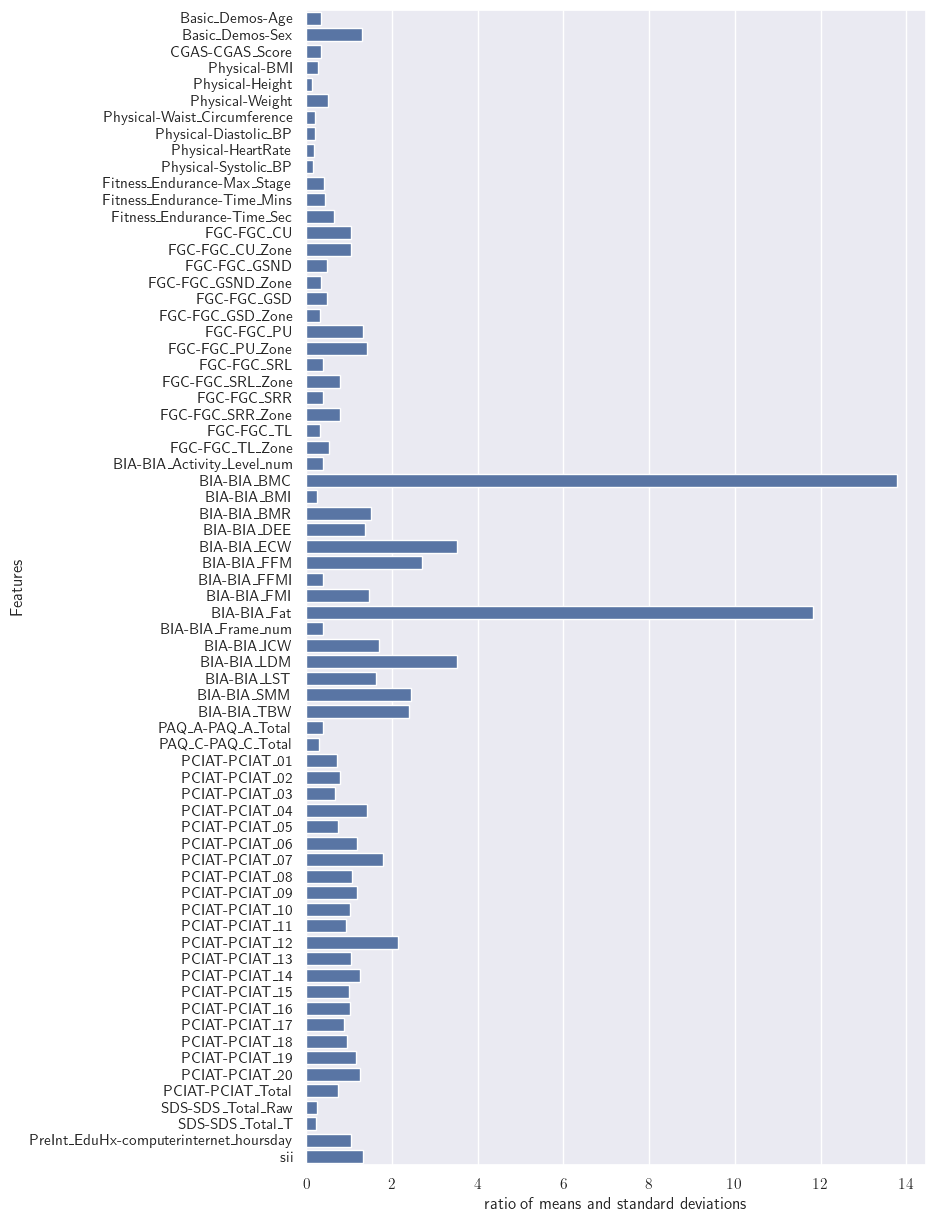

In [7]:
plt.figure(figsize=(8,15))

sns.barplot(y=ratios.columns, x=ratios.values.flatten())
plt.xlabel(r'ratio of means and standard deviations')
plt.ylabel(r'Features')
plt.show()

These are the different attributes contained the training data. The metadata file associated with these attributes is ```data_dictionary.csv``` which describes what these attributes are and what kinds of values they take. The feature columns can be broken down into feature categories depending on their prefixes. This can be done by observing that each category prefix is followed by a hyphen '-'.

In [8]:
features = train_df.columns.to_list()

features

['id',
 'Basic_Demos-Enroll_Season',
 'Basic_Demos-Age',
 'Basic_Demos-Sex',
 'CGAS-Season',
 'CGAS-CGAS_Score',
 'Physical-Season',
 'Physical-BMI',
 'Physical-Height',
 'Physical-Weight',
 'Physical-Waist_Circumference',
 'Physical-Diastolic_BP',
 'Physical-HeartRate',
 'Physical-Systolic_BP',
 'Fitness_Endurance-Season',
 'Fitness_Endurance-Max_Stage',
 'Fitness_Endurance-Time_Mins',
 'Fitness_Endurance-Time_Sec',
 'FGC-Season',
 'FGC-FGC_CU',
 'FGC-FGC_CU_Zone',
 'FGC-FGC_GSND',
 'FGC-FGC_GSND_Zone',
 'FGC-FGC_GSD',
 'FGC-FGC_GSD_Zone',
 'FGC-FGC_PU',
 'FGC-FGC_PU_Zone',
 'FGC-FGC_SRL',
 'FGC-FGC_SRL_Zone',
 'FGC-FGC_SRR',
 'FGC-FGC_SRR_Zone',
 'FGC-FGC_TL',
 'FGC-FGC_TL_Zone',
 'BIA-Season',
 'BIA-BIA_Activity_Level_num',
 'BIA-BIA_BMC',
 'BIA-BIA_BMI',
 'BIA-BIA_BMR',
 'BIA-BIA_DEE',
 'BIA-BIA_ECW',
 'BIA-BIA_FFM',
 'BIA-BIA_FFMI',
 'BIA-BIA_FMI',
 'BIA-BIA_Fat',
 'BIA-BIA_Frame_num',
 'BIA-BIA_ICW',
 'BIA-BIA_LDM',
 'BIA-BIA_LST',
 'BIA-BIA_SMM',
 'BIA-BIA_TBW',
 'PAQ_A-Season',

The different feature categories are extracted using the ```feature_cat()``` function, which takes in the features column and applies regex to extract features before return a sorted list of unique categories.

In [9]:
# Function for making feature categories

def feature_cat(features):
    ''' 
    This function takes in the feature column and applies regex iteratively to obtain the different unique
    feature categories. It returns a sorted list of the different categories.
    '''
    types = []

    for n, feature in enumerate(features):
        match = re.findall('.+-', feature) # using regex to extract subfeature

        if len(match) == 1:
            match = match[0][:-1]
            types.append(match)

    # Reduces the list to only contain unique categories and sorts it
    unique_list = list(set(types))
    sorted_list = sorted(unique_list)

    return sorted_list

feature_categories = feature_cat(features) 

print(feature_categories)

['BIA', 'Basic_Demos', 'CGAS', 'FGC', 'Fitness_Endurance', 'PAQ_A', 'PAQ_C', 'PCIAT', 'Physical', 'PreInt_EduHx', 'SDS']


The subfeatures within each feature category can also be extracted using the ```subfeatures()``` function. The following function extracts the subcategories, expect the 'Season' categories.

In [10]:
# Function for making subfeatures of each category

def subfeatures(features, feature_cat, simplify=True):
    ''' 
    This functions takes in the feature column and a particular feature category as inputs and returns a sorted 
    list of subcategories.

    The optional 'simplify' argument, if set to False, will prepend the feature category to the subcategories. 
    '''
    subfeatures = []

    for n, feature in enumerate(features):
        match = re.findall(feature_cat, feature)

        if not 'Enroll_Season' or not 'Season' in feature:
            
            if len(match) != 0:
                if simplify==True:
                    subfeature = feature.split('-')[-1]
                    subfeatures.append(subfeature)
                else:
                    subfeature = feature.split('-')[-1]
                    subfeatures.append(feature)
    
    return sorted(subfeatures)

print(subfeatures(features, 'Basic_Demos'))
print(subfeatures(features, 'Basic_Demos', simplify=False))

['Age', 'Sex']
['Basic_Demos-Age', 'Basic_Demos-Sex']


We can confirm that there are a large numbe of missing entries for a lot of these attributes. Even the target feature ```sii``` contains missing values, hinting at the fact that the dataset will require a semi-supervised learning approach. The highest proportion of missing data arises from the 'Physical Activity Questionnaire' ```PAQ``` with both FitnessGram data following suite (```Fitness_Endurance``` and ```FGC```). 

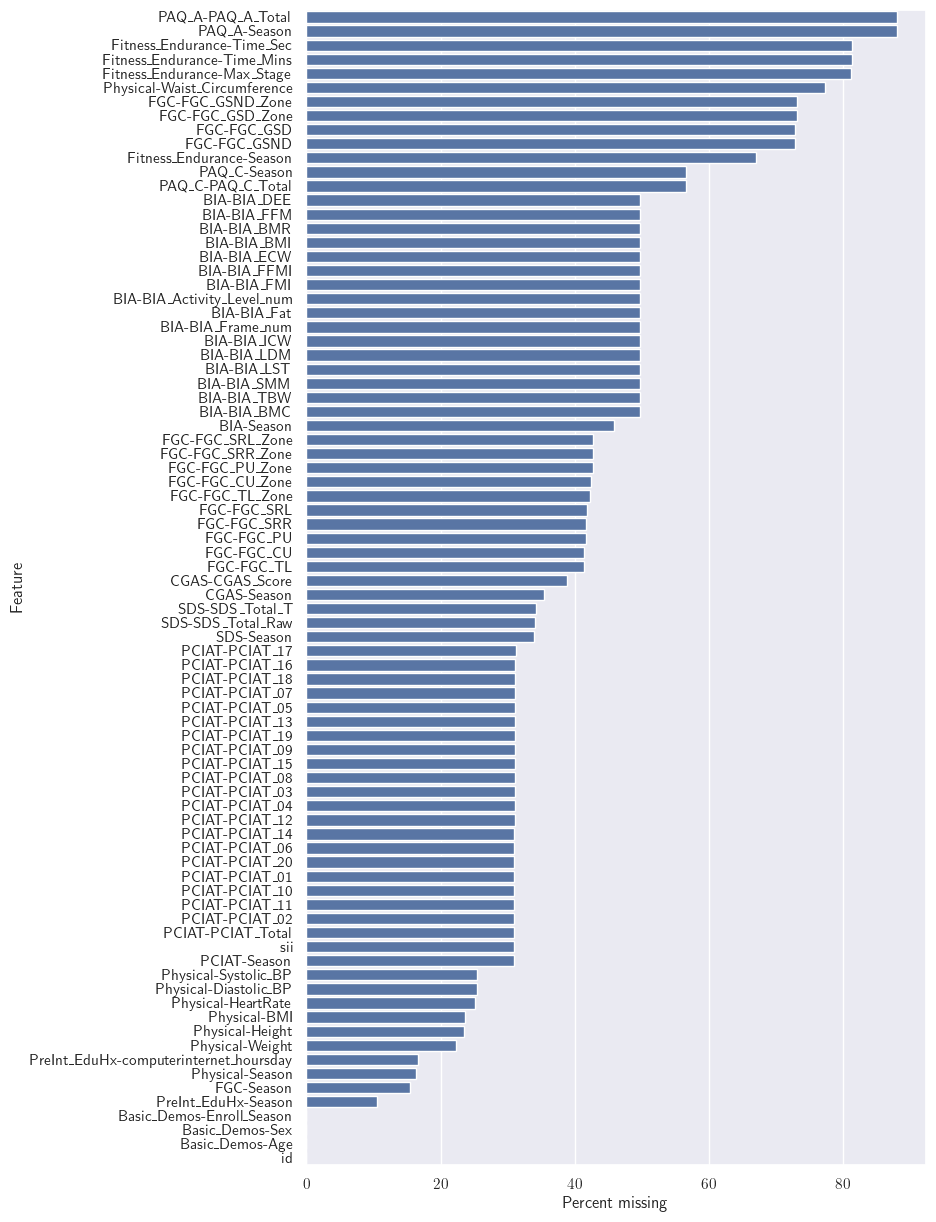

In [11]:
def plot_na(data):
    if data.isna().sum().sum() != 0: # checks if there are NaN values
        na_data = (data.isna().sum().sort_values(ascending=False))/len(data) *100
        missing_data = pd.DataFrame({'Feature': na_data.index, 'Percent missing': na_data.values})

        fig, ax = plt.subplots(figsize=(8, 15))
        sns.barplot(missing_data, y='Feature', x='Percent missing', ax=ax)
    else:
        print('No missing data found.')

plot_na(train_df)

The plot of missing data can be filtered on the subset of the data for which the training label has been provided. We observe a very strong correlation between ```sii``` and the different categories of ```PCIAT```, which is the 'Parent-Child Internet Addiction Test'.

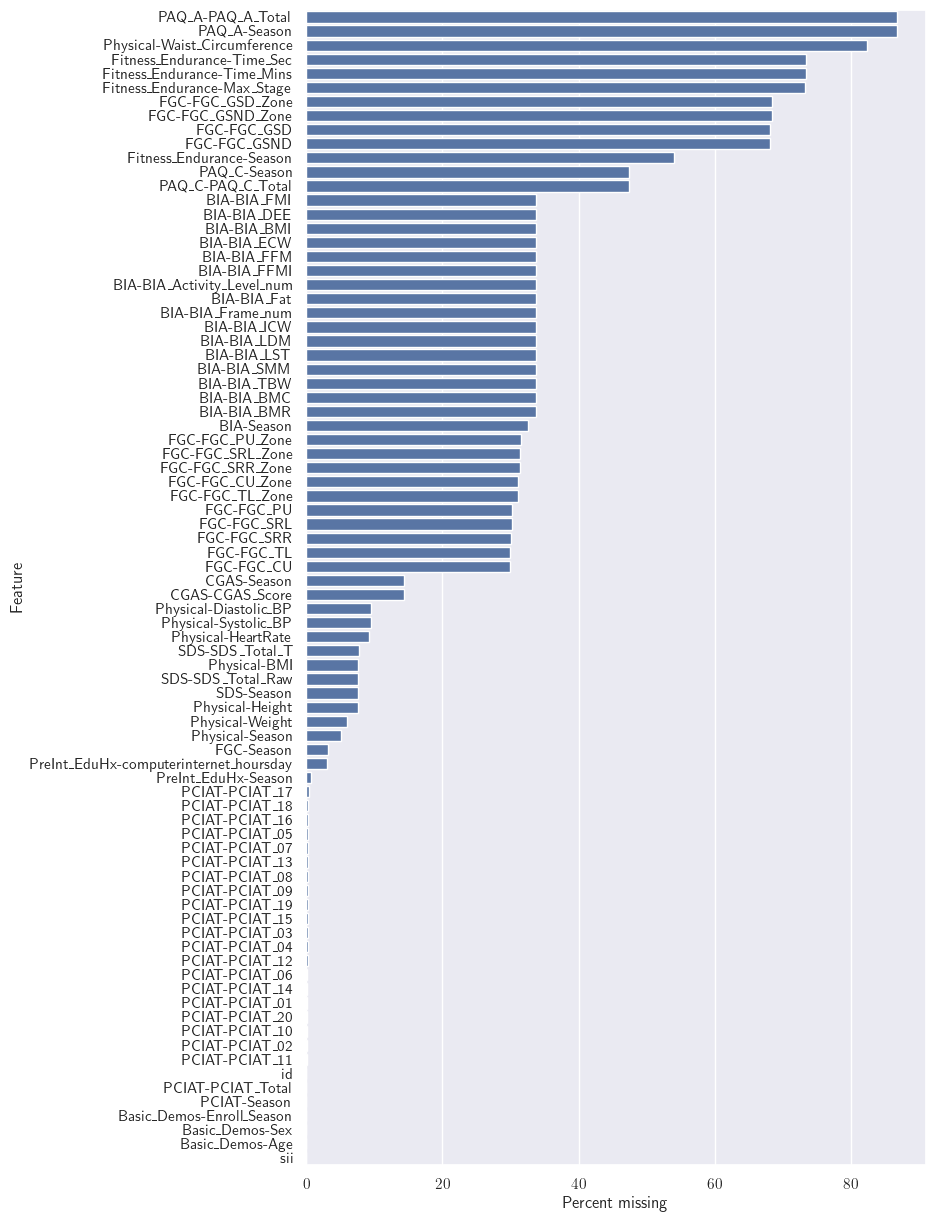

In [12]:
# Missing values in the subset where the target label is provided

plot_na(train_df[train_df['sii'].notna()])

Is there any correlation between ```PCIAT_Total``` and ```sii```? There is certainly a correlation which proceedes as a collection of step functions. As the ```data_dictionary.csv``` file suggests, the 'Severity Impairment Index' is given by
* None: $0-30$
* Mild: $31-49$
* Moderate: $50-79$
* Severe: $80-100$

Based on this, the ```sii``` mapping is formed.

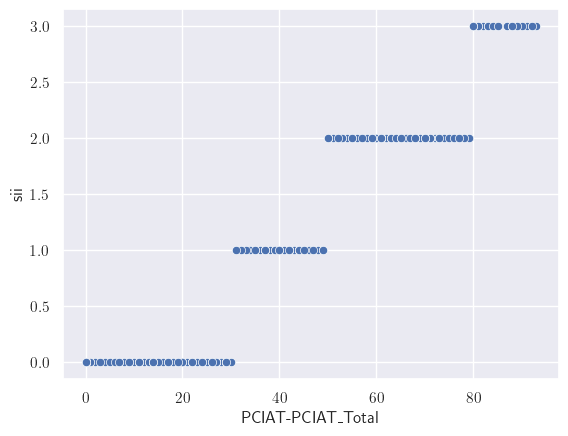

In [13]:
sns.scatterplot(train_df, x='PCIAT-PCIAT_Total', y='sii')
plt.show()

## EDA
Here we perform exploratory data analysis (EDA) on the different feature categories to study the data spread, finding outliers and correlations.

### Demographic information

The demographic category contains information on two subcategories -
* Sex: labeled as '0' (male) and '1' (female)
* Age

We see that male participants are overly representative of the data. The median age of the participants is $10.5\:\rm{years}$.

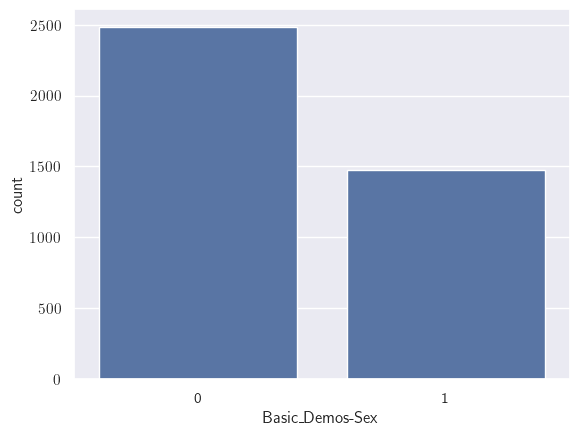

In [14]:
sns.countplot(train_df, x='Basic_Demos-Sex')
plt.show()

The participants in the training data have a mean age of $10.4$ years with the age distribution displaying little outlier behavior.

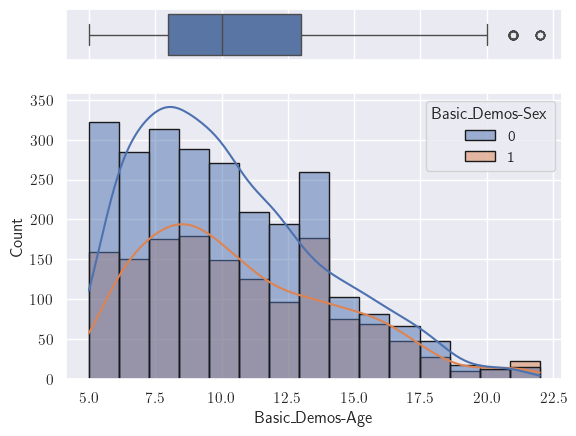

In [15]:
fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                    gridspec_kw={"height_ratios": (.15, .85)})

sns.boxplot(train_df, x='Basic_Demos-Age', ax=ax_box) 
sns.histplot(train_df, x='Basic_Demos-Age', ax=ax_hist, hue='Basic_Demos-Sex', bins=15, kde=True, edgecolor="k")

plt.show()

### Physical
The 'Physical' feature contains seven numerical features
1. Body-Mass Index (BMI): a ratio of the mass in kilograms and height in meters
2. Height in meters
3. Weight in kilograms
4. Waist cirumference in meters
5. Systolic blood pressure in mmHg
6. Diastolic blood pressure in mmHg
7. Heart rate in BPM: It is not mentioned if it is resting heart rate or not. It is likely not, since there is a wide spread of values.

From here, we also see that the sex labeled with '0' displays greater heights and weights, from which we can conclude that '0' and '1' refer to 'male' and 'female'. The histograms for these subcategories are shown where the dashed, black lines indicate the $25\%$ quantile, median and $75\%$ quantile respectively.

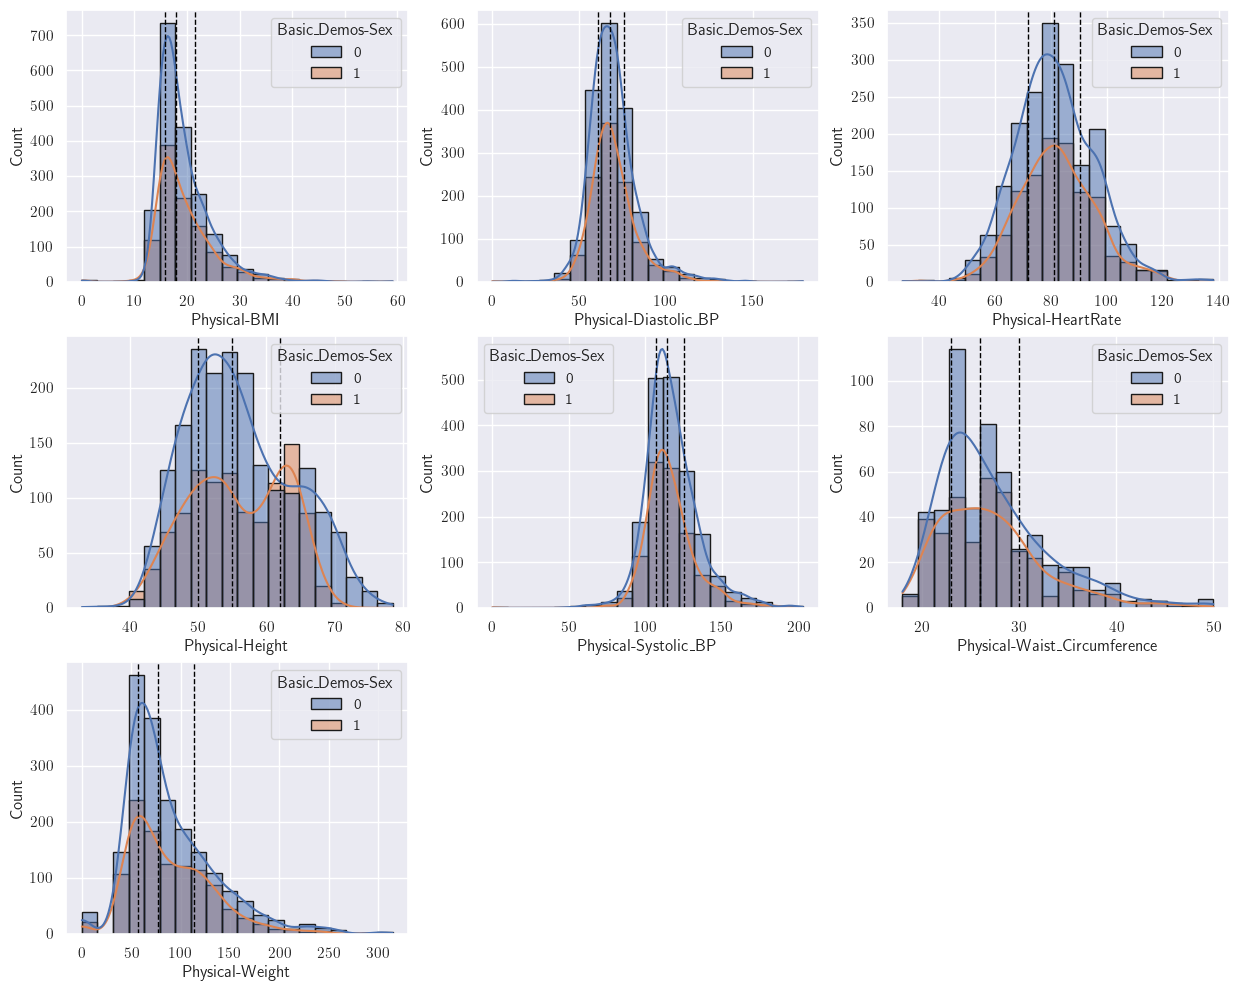

In [16]:
PHYSICAL_TYPES = subfeatures(features, 'Physical', simplify=False)

plt.figure(figsize=(15, 12))

stats = train_df.describe()
for n, TYPE in enumerate(PHYSICAL_TYPES):
    ax_hist = plt.subplot(3, 3, n+1)

    # calculating stats
    median = train_df[TYPE].median()
    lq, uq = train_df[TYPE].quantile([0.25, 0.75])

    sns.histplot(train_df, x=TYPE, bins=20, hue='Basic_Demos-Sex', ax=ax_hist, kde=True, edgecolor='k')
    ax_hist.axvline(lq, linestyle='dashed', linewidth=1, color='black')
    ax_hist.axvline(median, linestyle='dashed', linewidth=1, color='black')
    ax_hist.axvline(uq, linestyle='dashed', linewidth=1, color='black')

plt.show()

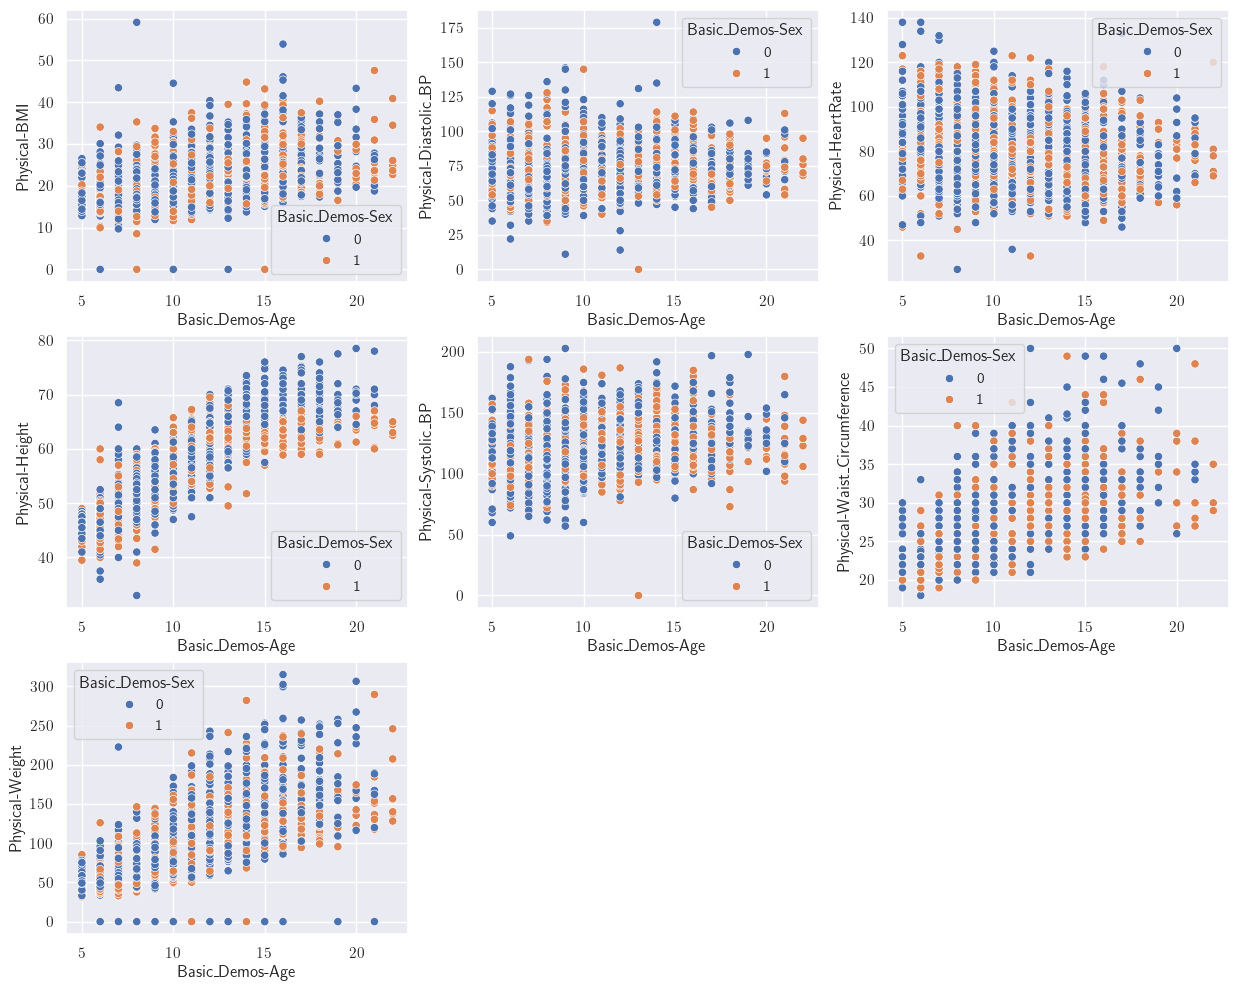

In [17]:
plt.figure(figsize=(15, 12))

for n, TYPE in enumerate(PHYSICAL_TYPES):
    ax_hist = plt.subplot(3, 3, n+1)

    sns.scatterplot(train_df, x='Basic_Demos-Age', y=TYPE, hue='Basic_Demos-Sex', ax=ax_hist)

plt.show()

The ```Physical``` attributes display significant outlier behavior. Moreover, we observe the presence of $0$ values in BMI, weight and systolic/diastolic pressures, which are clearly incorrect. The outliers in this category can be *winsorized* during data preparation.

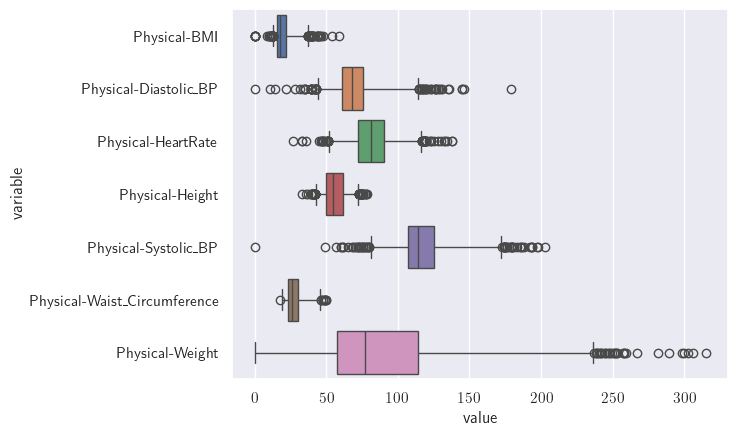

In [18]:
sns.boxplot(
    pd.melt(train_df[PHYSICAL_TYPES]),   
    y='variable',
    x='value',
    hue='variable',
    whis=[1,99]
)
plt.show()

We cap the range of values for all the features in the ```Physical``` category to $5^\text{th}$ and $99^\text{th}$ quantiles.

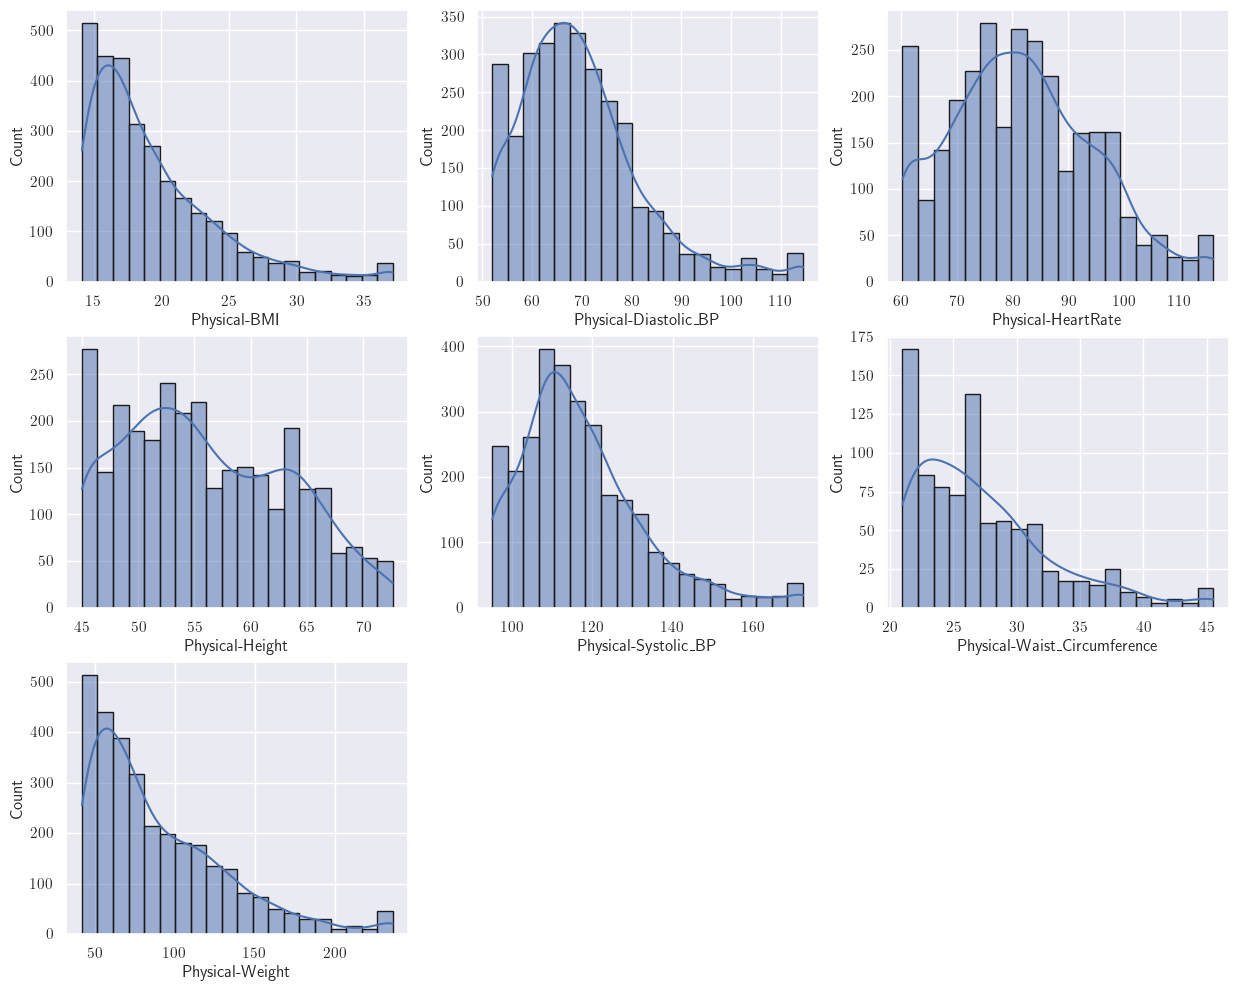

In [19]:
plt.figure(figsize=(15, 12))

for n, TYPE in enumerate(PHYSICAL_TYPES):
    ax_hist = plt.subplot(3, 3, n+1)
    data_clipped = train_df[TYPE].clip(
        lower=train_df[TYPE].quantile(0.05),
        upper=train_df[TYPE].quantile(0.99)
    )
    sns.histplot(x=data_clipped, bins=20, ax=ax_hist, kde=True, edgecolor='k')
plt.show()

We observe that there are some discrepancies in the blood pressure readings. The systolic BP is always higher than diastolic. However, we find a systolic BP readings few that are equal to or lower diastollic. 

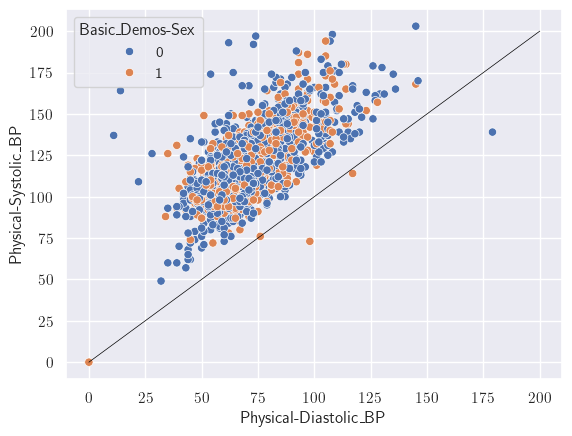

In [20]:
sns.scatterplot(train_df, x='Physical-Diastolic_BP', y='Physical-Systolic_BP', hue='Basic_Demos-Sex')
plt.plot([0, 200], [0, 200], linewidth=0.5, color='black')
plt.show()

Moreover, there are very high and low BPs and it will be interesting to check if there is any correlation with heart rate. This might indicate if the blood pressures were recorded during activity or rest.

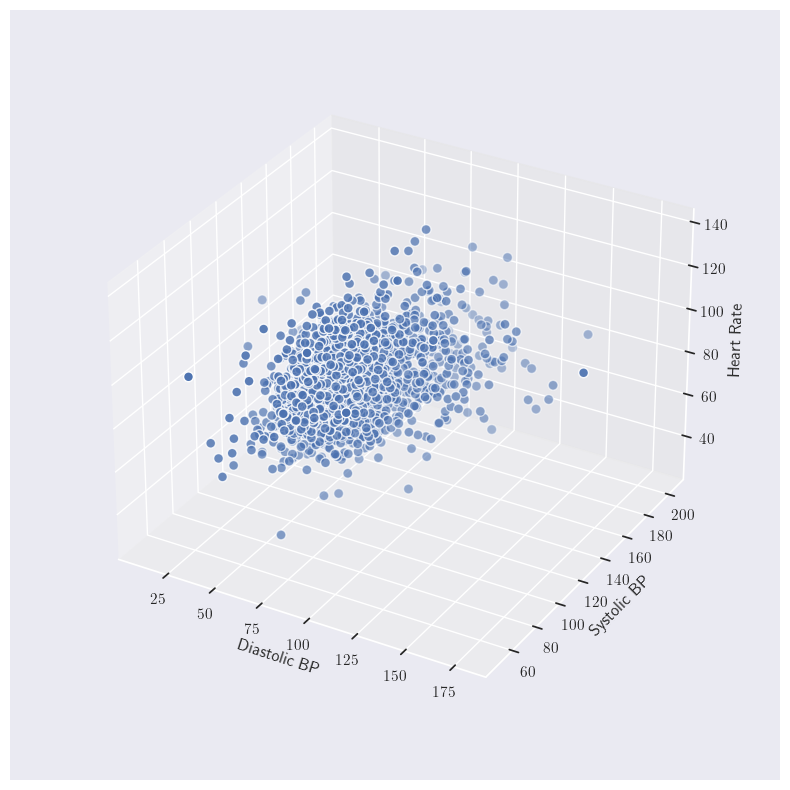

In [21]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

ax.scatter(
    train_df['Physical-Diastolic_BP'],
    train_df['Physical-Systolic_BP'],
    train_df['Physical-HeartRate'],
    s=50,
    edgecolor='w'
)
ax.set_xlabel('Diastolic BP')
ax.set_ylabel('Systolic BP')
ax.set_zlabel('Heart Rate')

ax.set_box_aspect(None, zoom=0.85)
plt.show()

We observe that there is a positive relation between heart rate and systolic/diastolic BPs, as can be seen from the correlation heatmap. Other subfeatures in 'Physical' show some correlation among each other, as expected. We should also expect to see some correlation with those from the 'Fitness' category as well.

As for the improbable diastolic-systolic points, they can be changed by adopting a simple relation
$$ \text{systolic BP} \approx 1.5 \times \text{diastolic BP} $$
This comes from the fact that the normal blood pressure (at least in adults) is $120\:\text{mmHg}$ for systolic and $80\:\text{mmHg}$ for diastolic, which is a ratio of $1.5$. 

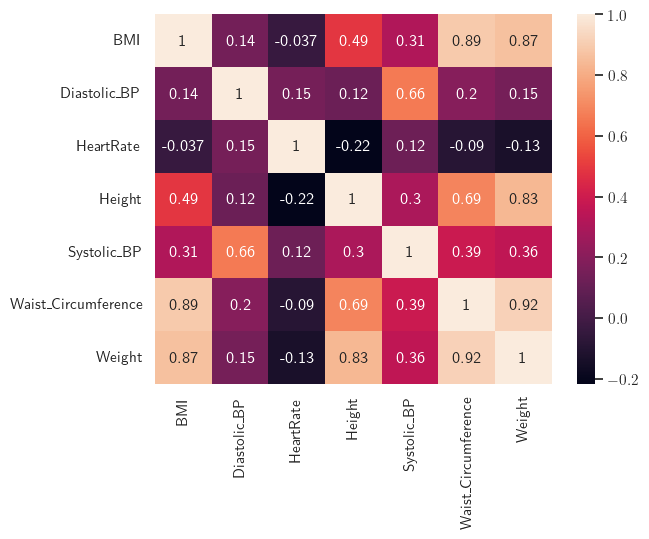

In [22]:
xticklabels = subfeatures(features, 'Physical')
yticklabels = subfeatures(features, 'Physical')

sns.heatmap(train_df[PHYSICAL_TYPES].corr(), annot=True, xticklabels=xticklabels, yticklabels=yticklabels)
plt.show()

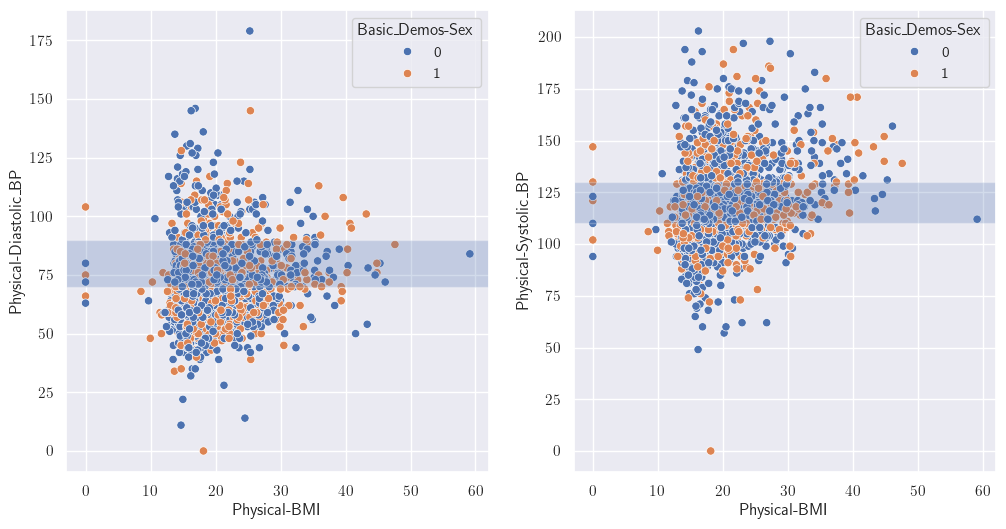

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

sns.scatterplot(train_df, x='Physical-BMI', y='Physical-Diastolic_BP', ax=ax[0], hue='Basic_Demos-Sex')
ax[0].axhspan(70, 90, alpha=0.25)

sns.scatterplot(train_df, x='Physical-BMI', y='Physical-Systolic_BP', ax=ax[1], hue='Basic_Demos-Sex')
ax[1].axhspan(110, 130, alpha=0.25)

plt.show()

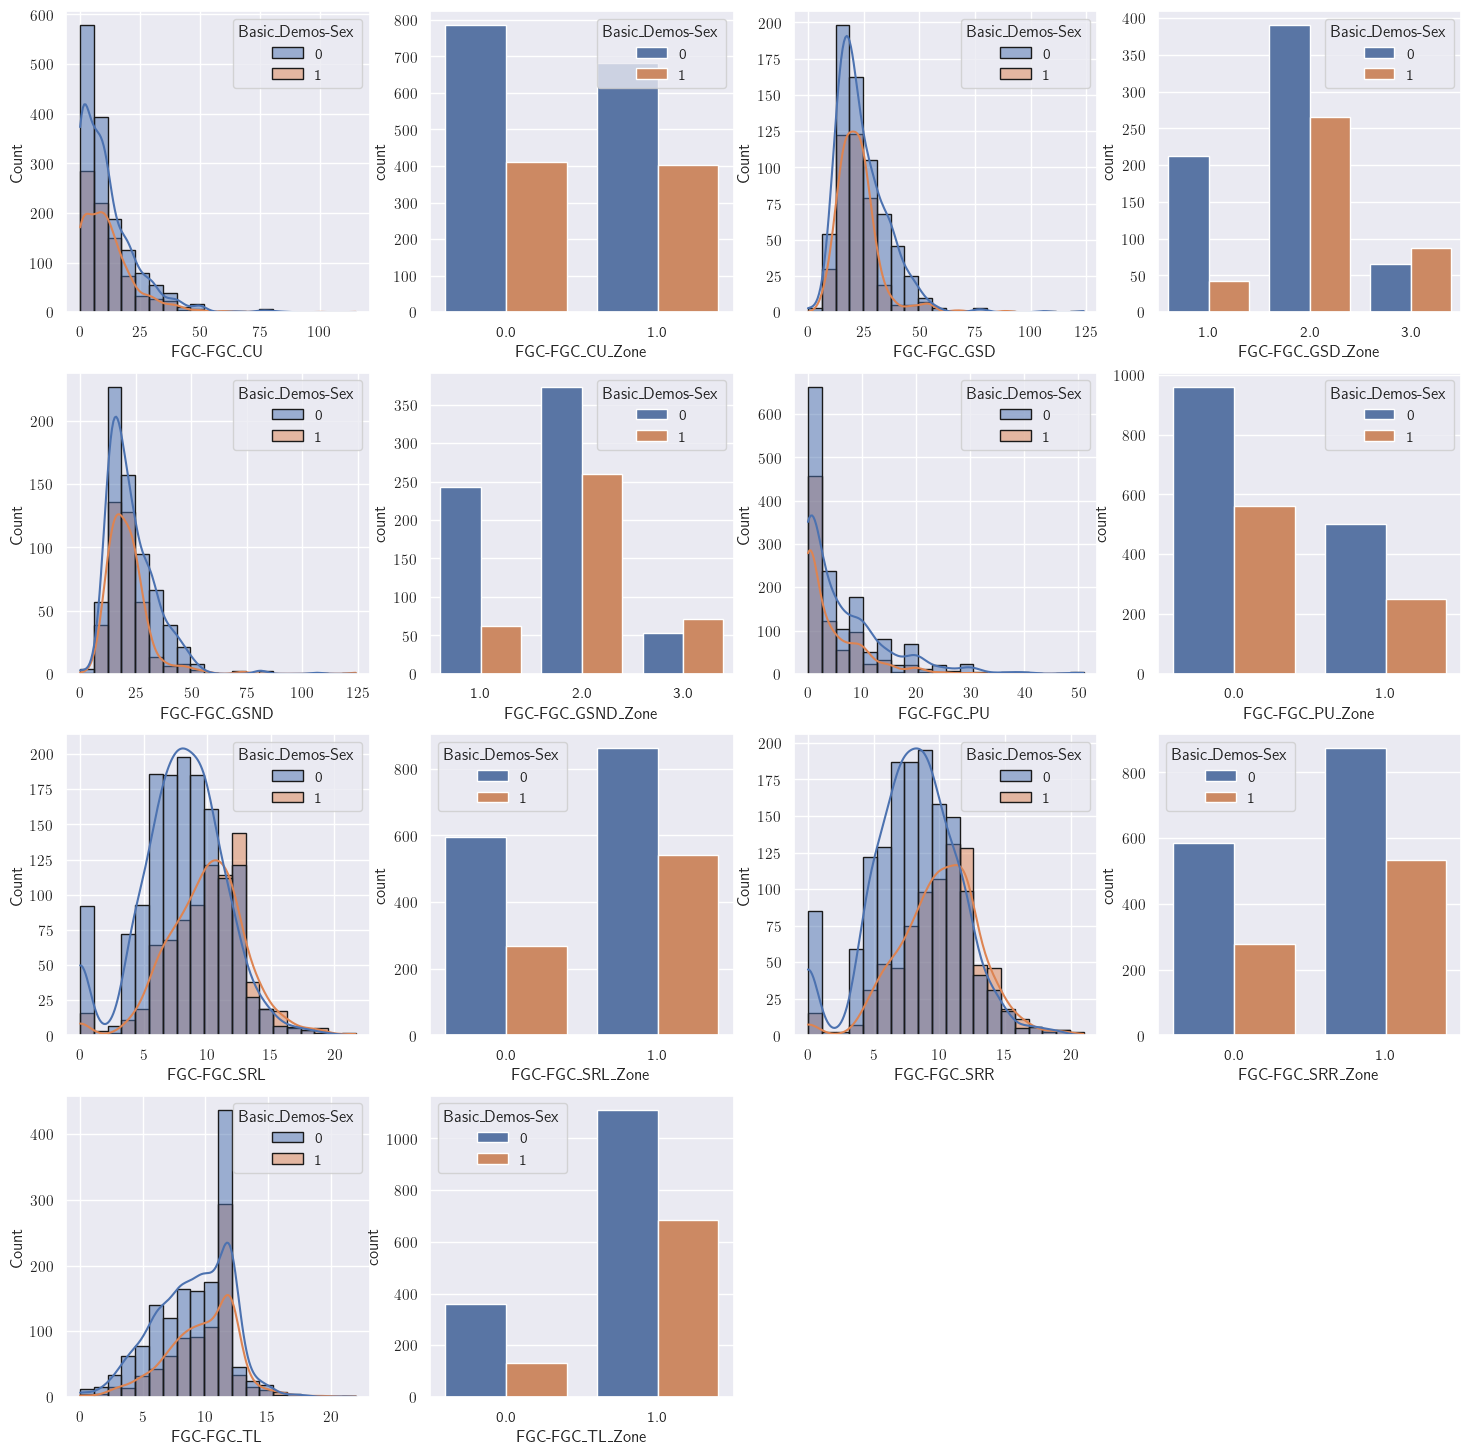

In [24]:
FGC_TYPES = subfeatures(features, 'FGC', simplify=False)

plt.figure(figsize=(18, 18))

#stats = train_df.describe()
for n, TYPE in enumerate(FGC_TYPES):
    ax = plt.subplot(4, 4, n+1)
    if TYPE.split('_')[-1] != 'Zone':
        sns.histplot(train_df, x=TYPE, ax=ax, bins=20, hue='Basic_Demos-Sex', kde=True, edgecolor='k')
        #calculating stats
        #median = train_df[TYPE].median()
        #lq, uq = train_df[TYPE].quantile([0.25, 0.75])

        #ax.axvline(lq, linestyle='dashed', linewidth=1, color='black')
        #ax.axvline(median, linestyle='dashed', linewidth=1, color='black')
        #ax.axvline(uq, linestyle='dashed', linewidth=1, color='black')

    else:
        sns.countplot(train_df, x=TYPE, hue='Basic_Demos-Sex')
   

plt.show()

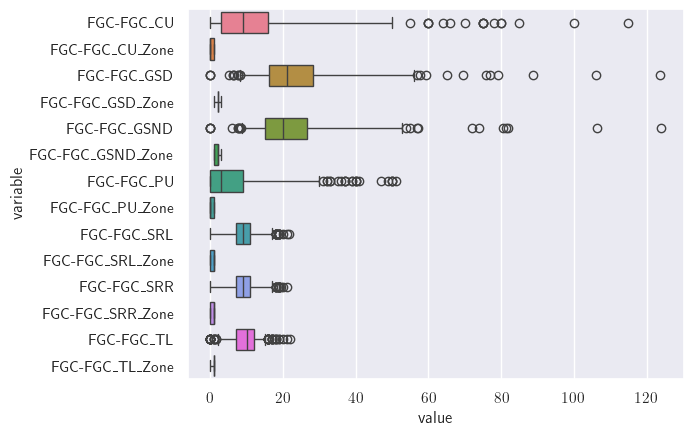

In [25]:
sns.boxplot(
    pd.melt(train_df[FGC_TYPES]),   
    y='variable',
    x='value',
    hue='variable',
    whis=[1,99]
)
plt.show()

Now we can check if the ```Physical``` and ```FGC``` categories have correlations amongst the different subcategories.

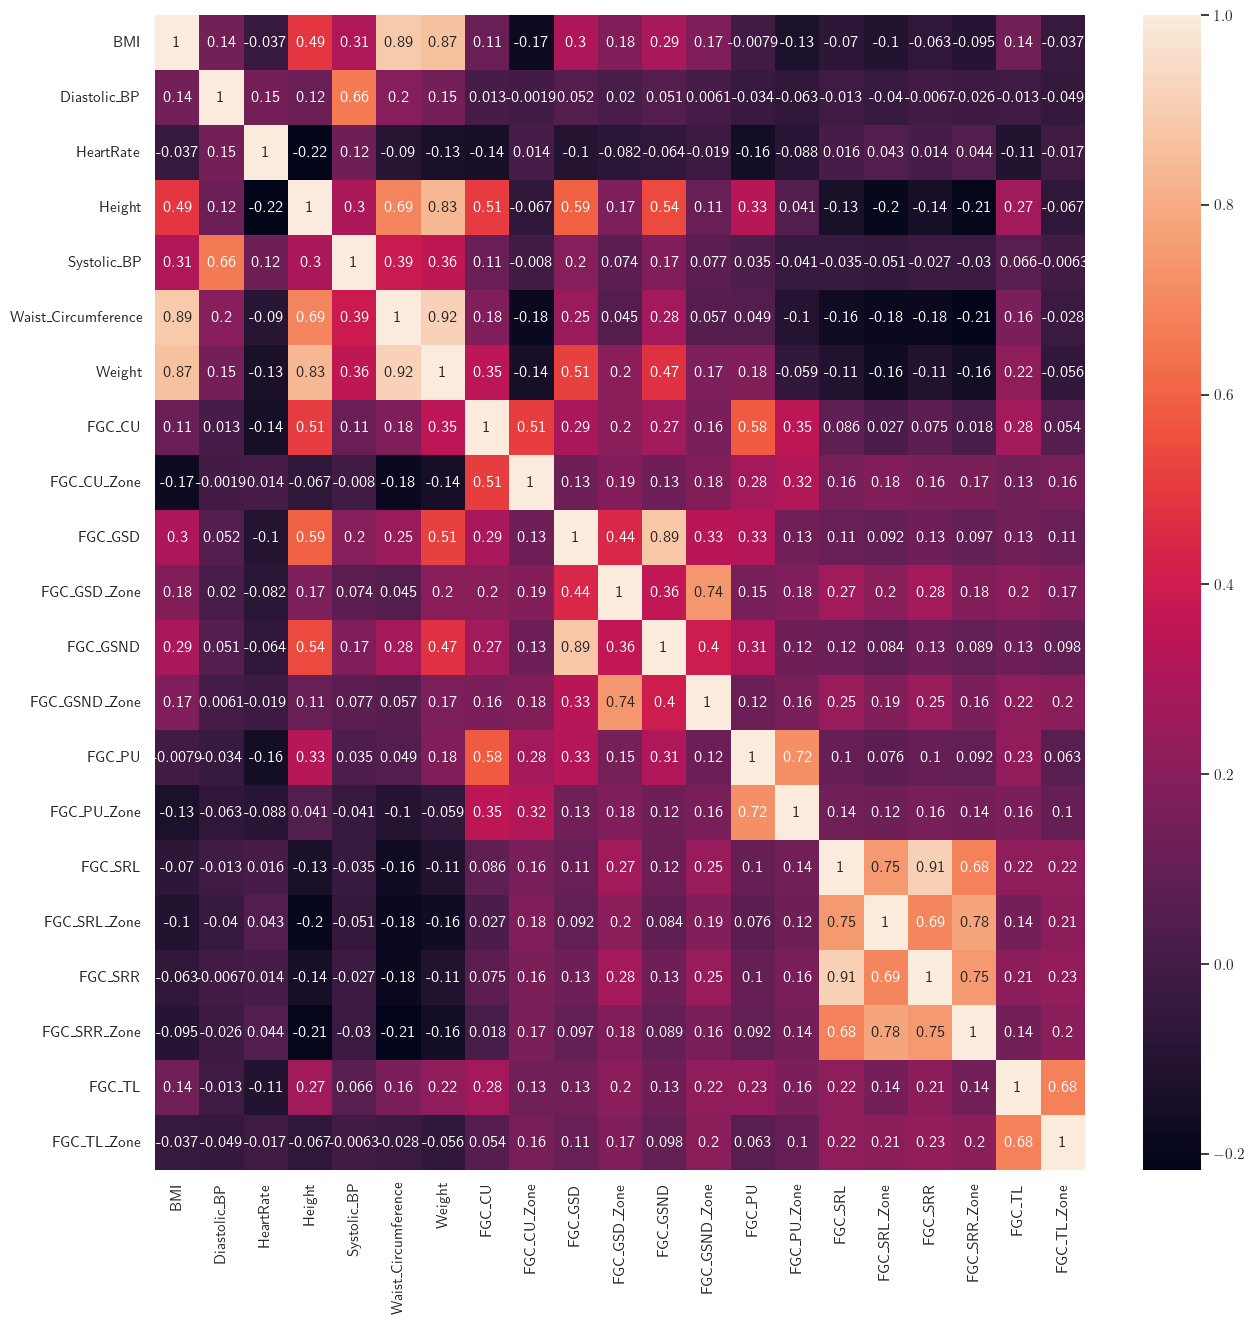

In [26]:
xticklabels = subfeatures(features, 'Physical') + subfeatures(features, 'FGC')
yticklabels = subfeatures(features, 'Physical') + subfeatures(features, 'FGC')

plt.figure(figsize=(15, 15))
sns.heatmap(train_df[PHYSICAL_TYPES + FGC_TYPES].corr(), annot=True, xticklabels=xticklabels, yticklabels=yticklabels)

plt.show()

### Bio-electric Impedance Analysis

It appears that there are significant discrepencies in the various BIA subcategories. Although the values of these subcategories are clustered around a reasonable range, they usually include a rather range or small entry.

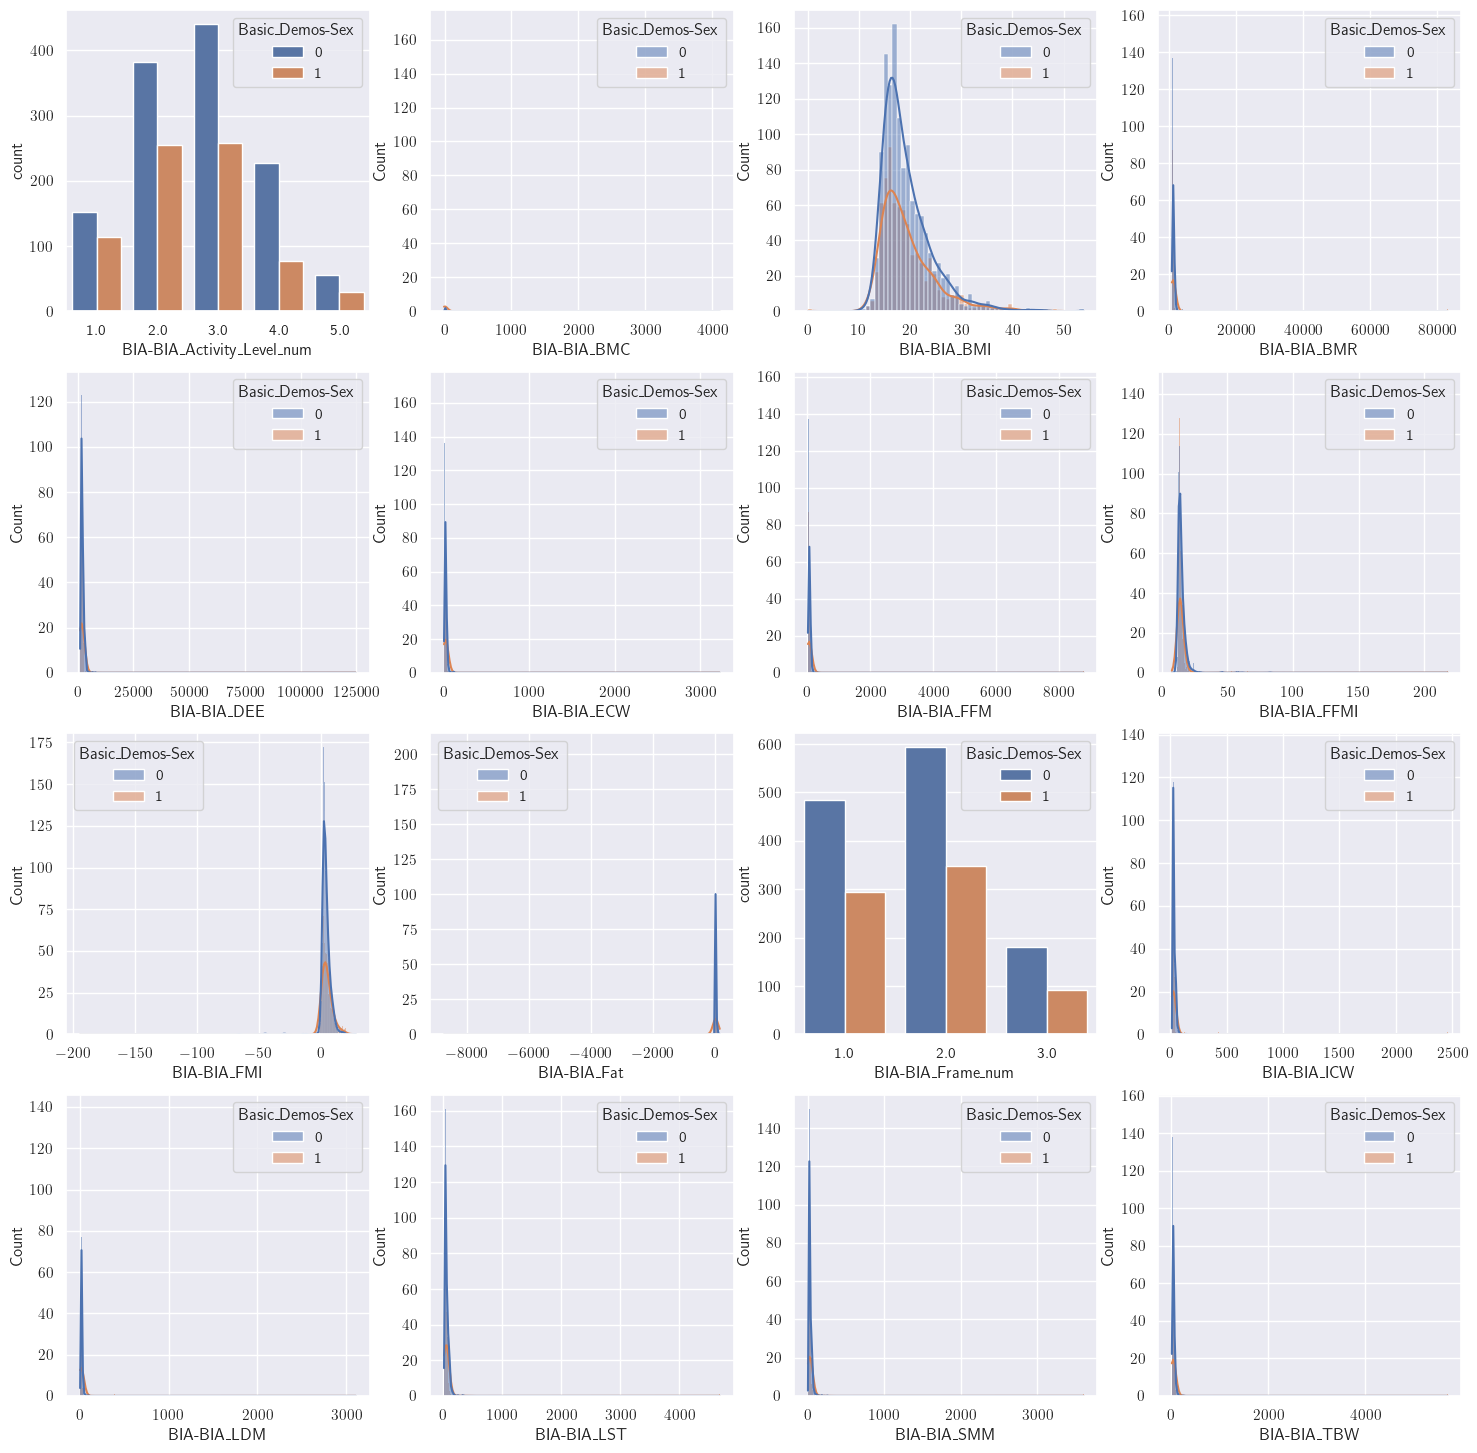

In [27]:
BIA_TYPES = subfeatures(features, 'BIA', simplify=False)

plt.figure(figsize=(18, 18))

for n, TYPE in enumerate(BIA_TYPES):
    ax = plt.subplot(4, 4, n+1)
    if TYPE.split('_')[-1] != 'num':
        sns.histplot(train_df, x=TYPE, ax=ax, hue='Basic_Demos-Sex', kde=True)

    else:
        sns.countplot(train_df, x=TYPE, hue='Basic_Demos-Sex')
   
#plt.savefig('BMI_plots.png', dpi=300, bbox_inches='tight')
plt.show()

In [28]:
train_df[BIA_TYPES].describe().T

count         mean          std          min  \
BIA-BIA_Activity_Level_num  1991.0     2.651431     1.028267     1.000000   
BIA-BIA_BMC                 1991.0     6.719826    92.586325    -7.789610   
BIA-BIA_BMI                 1991.0    19.367048     5.047848     0.048267   
BIA-BIA_BMR                 1991.0  1237.018187  1872.383246   813.397000   
BIA-BIA_DEE                 1991.0  2064.693747  2836.246272  1073.450000   
BIA-BIA_ECW                 1991.0    20.825346    73.266287     1.789450   
BIA-BIA_FFM                 1991.0    74.021708   199.433753    28.900400   
BIA-BIA_FFMI                1991.0    15.030554     5.792505     7.864850   
BIA-BIA_FMI                 1991.0     4.336495     6.356402  -194.163000   
BIA-BIA_Fat                 1991.0    16.855020   199.372119 -8745.080000   
BIA-BIA_Frame_num           1991.0     1.745354     0.680635     1.000000   
BIA-BIA_ICW                 1991.0    33.173380    56.272346    14.489000   
BIA-BIA_LDM                 1991.0    20.022990    70.215610     4.635810   
BIA-BIA_LST                 1991.0    67.301883   108.705918    23.620100   
BIA-BIA_SMM                 1991.0    34.389466    84.050607     4.655730   
BIA-BIA_TBW                 1991.0    53.998726   129.362539    20.589200   

                                    25%         50%          75%          max  
BIA-BIA_Activity_Level_num     2.000000     3.00000     3.000000       5.0000  
BIA-BIA_BMC                    2.966905     3.92272     5.460925    4115.3600  
BIA-BIA_BMI                   15.913600    17.96650    21.461100      53.9243  
BIA-BIA_BMR                 1004.710000  1115.38000  1310.360000   83152.2000  
BIA-BIA_DEE                 1605.785000  1863.98000  2218.145000  124728.0000  
BIA-BIA_ECW                   11.109550    15.92800    25.162200    3233.0000  
BIA-BIA_FFM                   49.278100    61.06620    81.833800    8799.0800  
BIA-BIA_FFMI                  13.408000    14.09250    15.430950     217.7710  
BIA-BIA_FMI                    2.306915     3.69863     5.987690      28.2515  
BIA-BIA_Fat                    8.602395    16.17460    30.273100     153.8200  
BIA-BIA_Frame_num              1.000000     2.00000     2.000000       3.0000  
BIA-BIA_ICW                   24.463500    28.85580    35.475700    2457.9100  
BIA-BIA_LDM                   12.983150    16.43880    22.167600    3108.1700  
BIA-BIA_LST                   45.204100    56.99640    77.105650    4683.7100  
BIA-BIA_SMM                   21.141550    27.41510    38.179400    3607.6900  
BIA-BIA_TBW                   35.887000    44.98700    60.271050    5690.9100

The same histograms are now plotted with the $x$-axes constrained within the $1^\text{st}$ and $99^\text{th}$ quantiles.

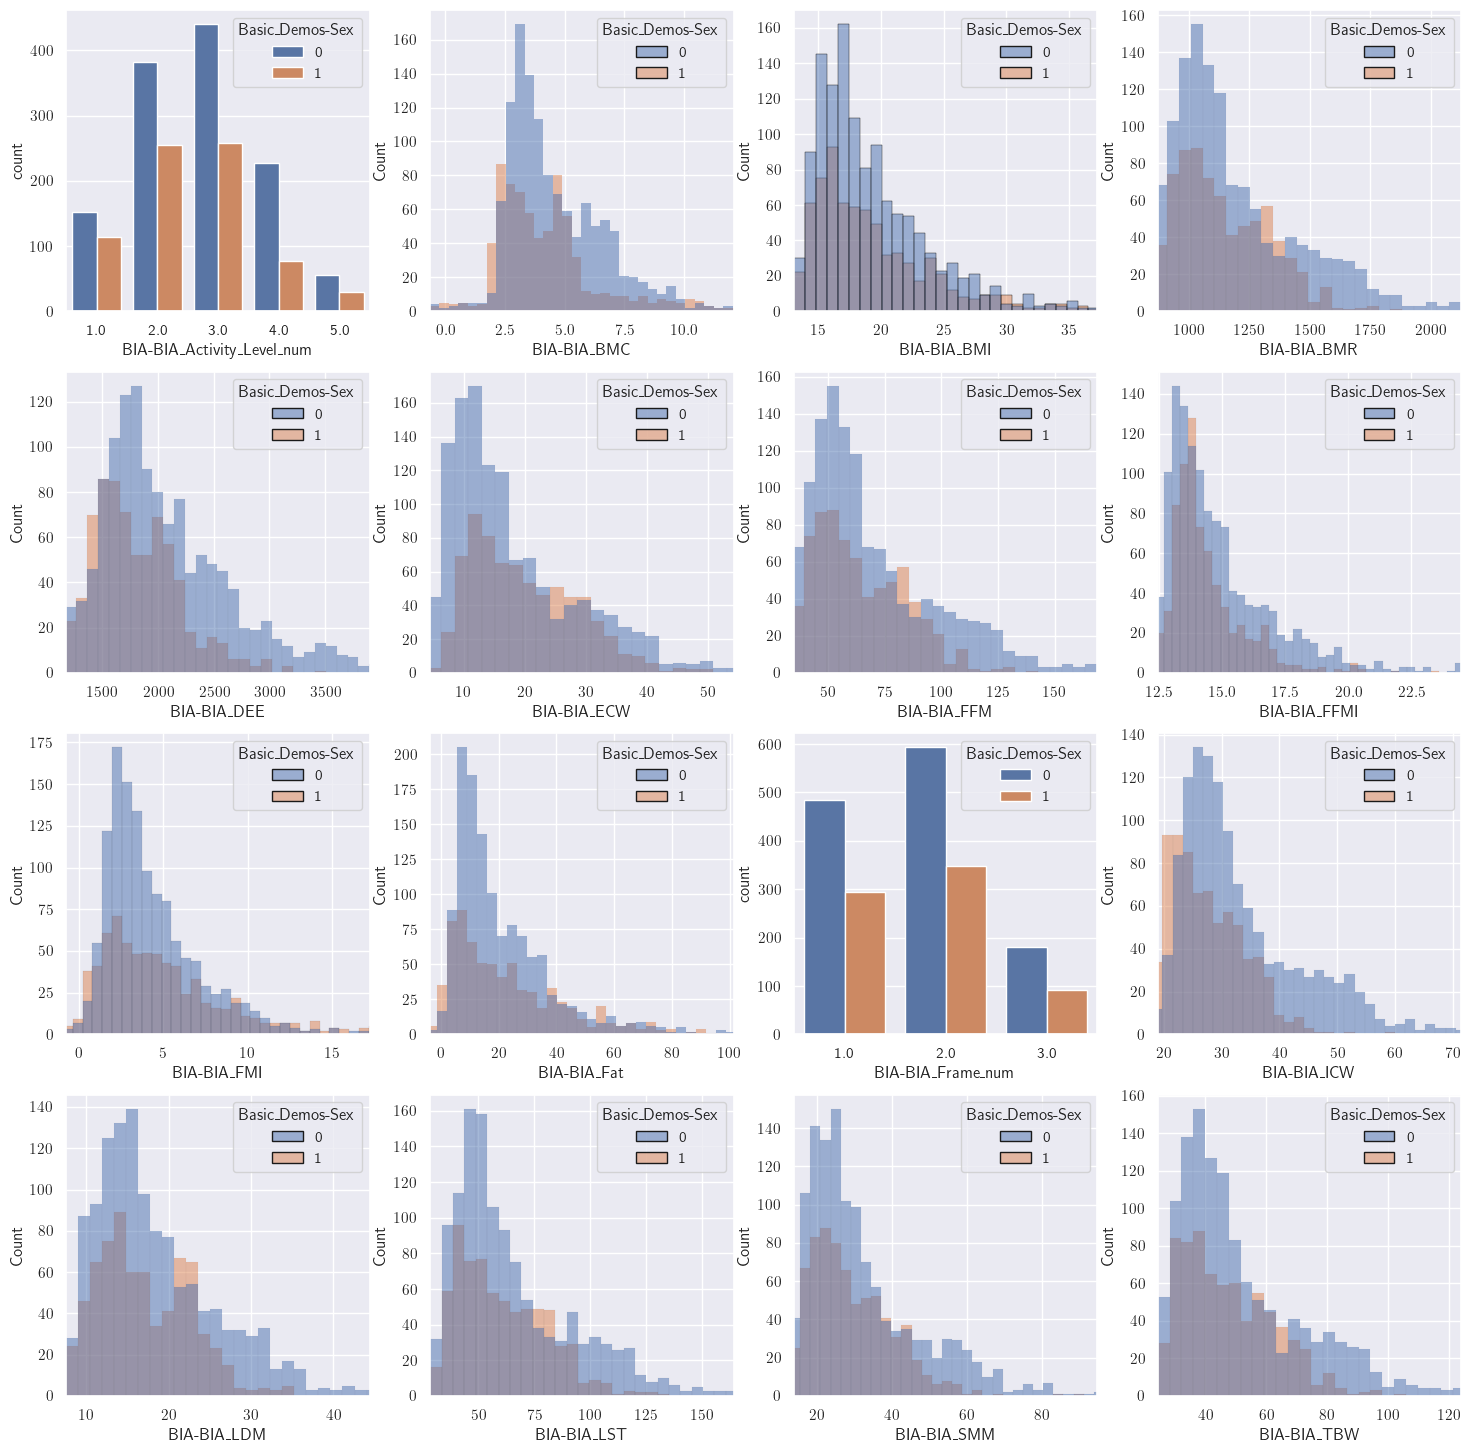

In [29]:
plt.figure(figsize=(18, 18))

stats = train_df.describe()
for n, TYPE in enumerate(BIA_TYPES):
    ax = plt.subplot(4, 4, n+1)
    if TYPE.split('_')[-1] != 'num':
        sns.histplot(train_df, x=TYPE, ax=ax, hue='Basic_Demos-Sex', edgecolor='k')
        #calculating stats
        #median = train_df[TYPE].median()
        low, high = train_df[TYPE].quantile([0.01, 0.99])
        plt.xlim(low, high)

        #ax.axvline(lq, linestyle='dashed', linewidth=1, color='black')
        #ax.axvline(median, linestyle='dashed', linewidth=1, color='black')
        #ax.axvline(uq, linestyle='dashed', linewidth=1, color='black')

    else:
        sns.countplot(train_df, x=TYPE, hue='Basic_Demos-Sex')
   
#plt.savefig('BMI_plots.png', dpi=300, bbox_inches='tight')
plt.show()

There are two sets of BMI measurements for some participants (```Physical-BMI``` and ```BIA-BIA_BMI```). The BMI measurements are fairly consistent, displaying some variation.

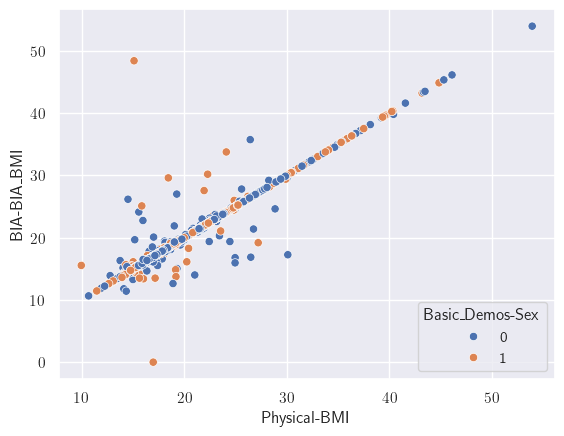

In [30]:
def BMI_compare(data):
    idx1 = data[data['Physical-BMI'].notna()].index # indices of Physical-BMI values
    idx2 = data[data['BIA-BIA_BMI'].notna()].index # indices of BIA-BIA_BMI values

    matches = idx1.intersection(idx2)

    data_matches = data.loc[matches, :]

    sns.scatterplot(data_matches, x='Physical-BMI', y='BIA-BIA_BMI', hue='Basic_Demos-Sex')
    plt.show()

BMI_compare(train_df)

### Parent-Child Internet Addiction Test (PCIAT)
The target label ```sii``` is based on the scores from the PCIAT, which consist of a series of $20$ questions related to childrens' internet usage, followed by an aggregate of the score. However, we note that the test dataset does not contain information on the ```PCIAT``` features due to such a high correlation between it and ```sii```.

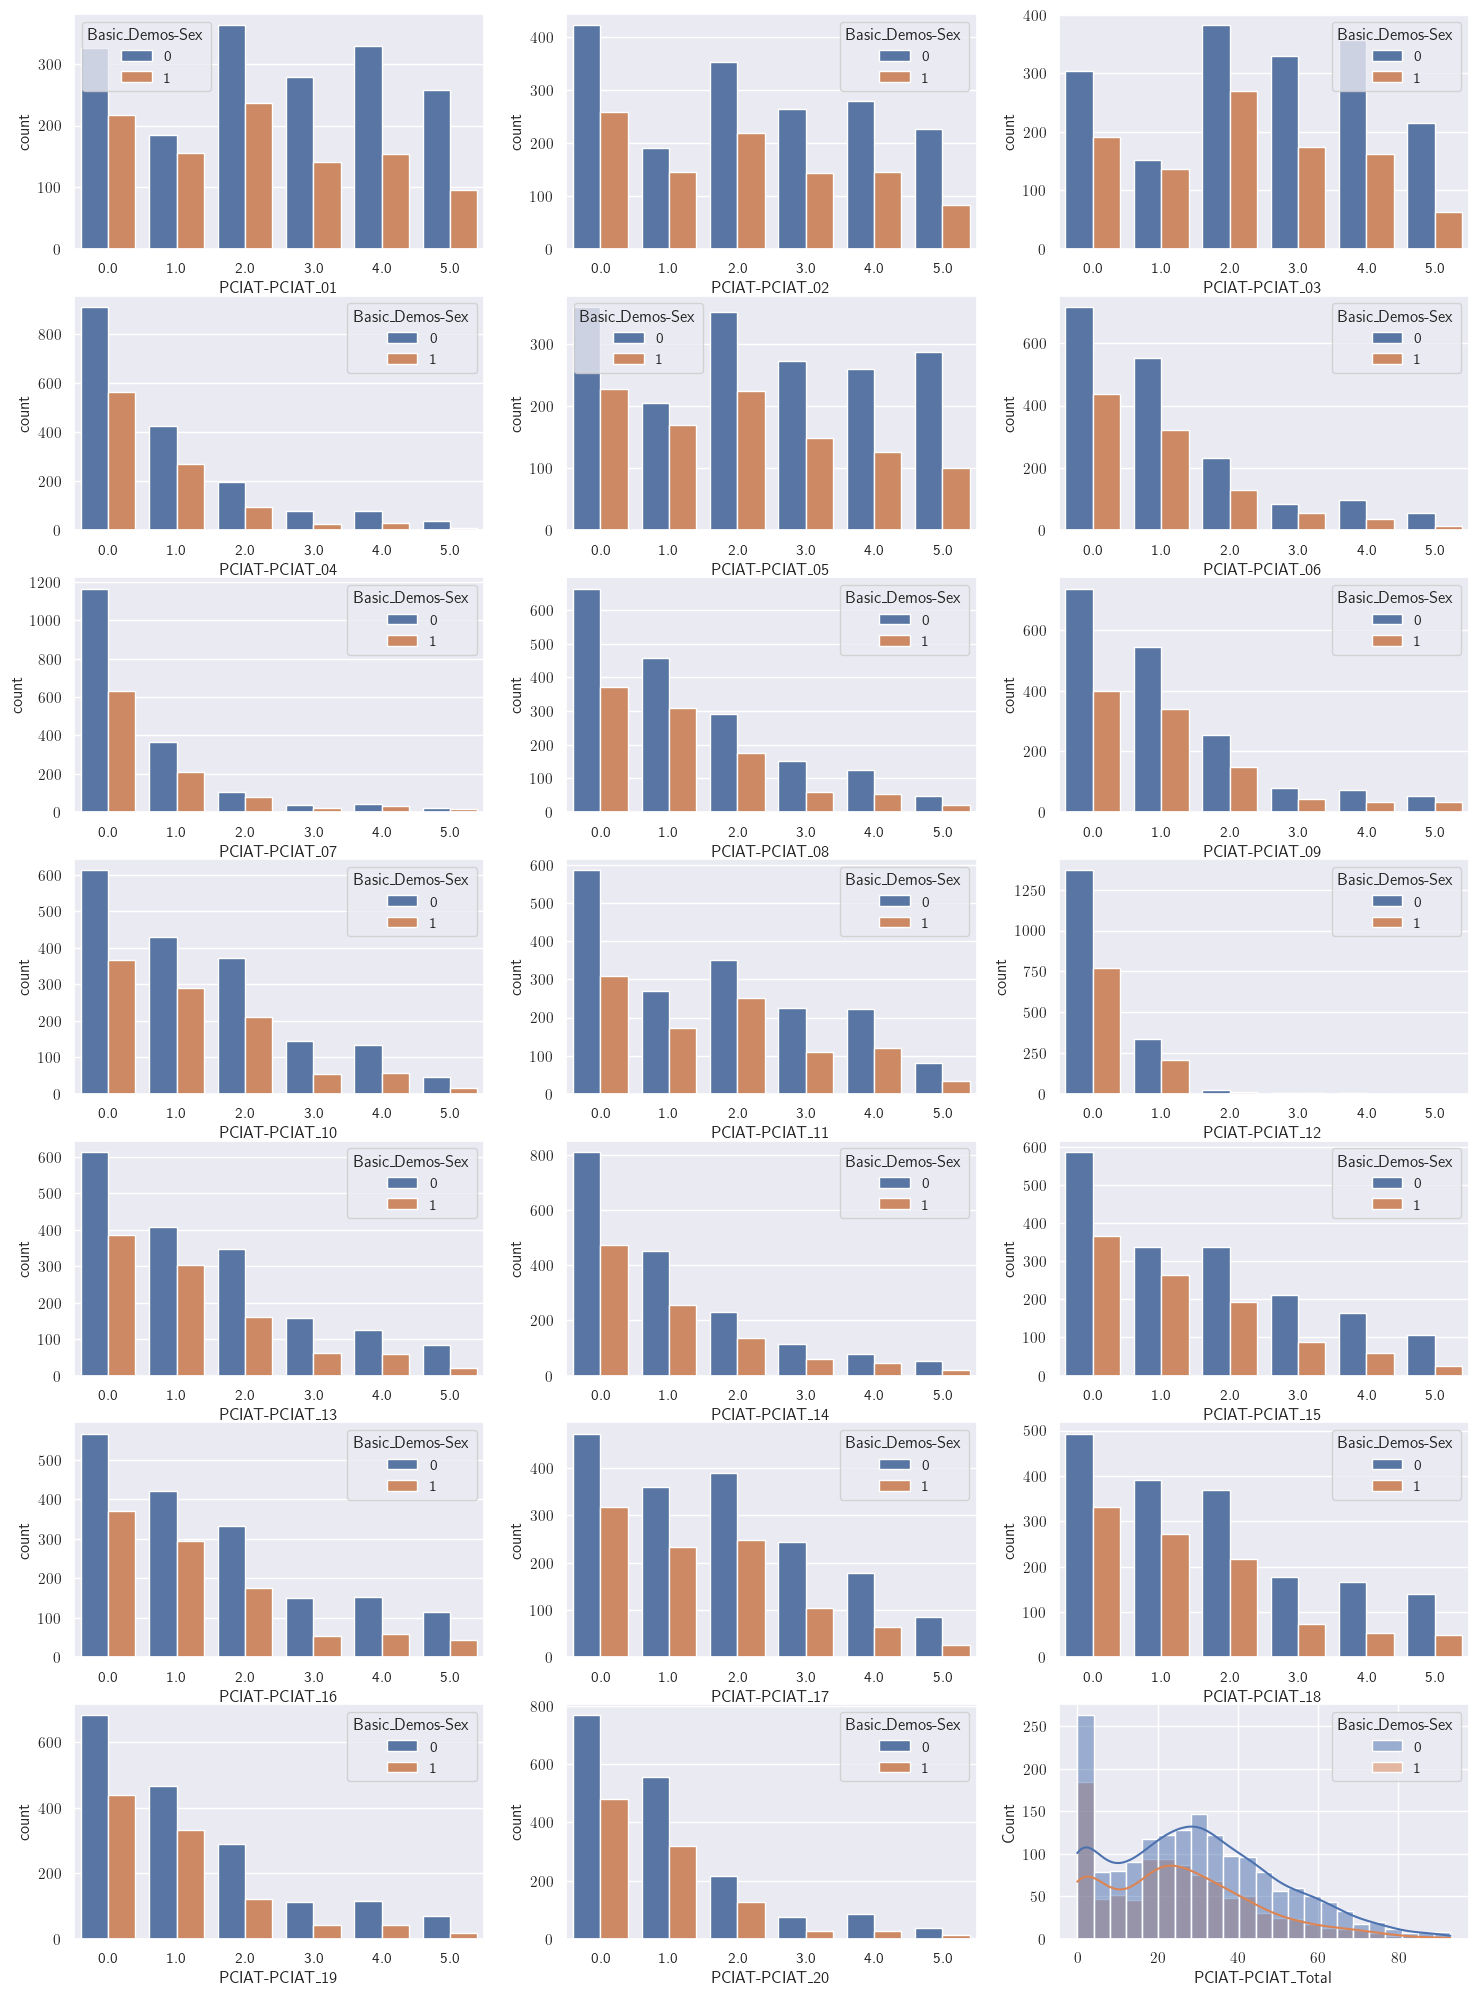

In [31]:
PCIAT_TYPES = subfeatures(features, 'PCIAT', simplify=False)

plt.figure(figsize=(18, 25))

for n, TYPE in enumerate(PCIAT_TYPES):
    ax = plt.subplot(7, 3, n+1)
    if TYPE.split('_')[-1] == 'Total':
        sns.histplot(train_df, x=TYPE, ax=ax, hue='Basic_Demos-Sex', kde=True)

    else:
        sns.countplot(train_df, x=TYPE, hue='Basic_Demos-Sex')
   
plt.show()

The ```SDS``` (sleep-disturbance scale) can also be an interesting marker for problematic internet usage. The reasoning behind this can be thought of as problematic internet usage leads to greater sleep disturbance in the sense that people are more likely to exposed to greater screen-time in the late hours, leading to sleep disturbance.

In [32]:
SDS_TYPES = subfeatures(features, 'SDS', simplify=False)

print(SDS_TYPES)

['SDS-SDS_Total_Raw', 'SDS-SDS_Total_T']


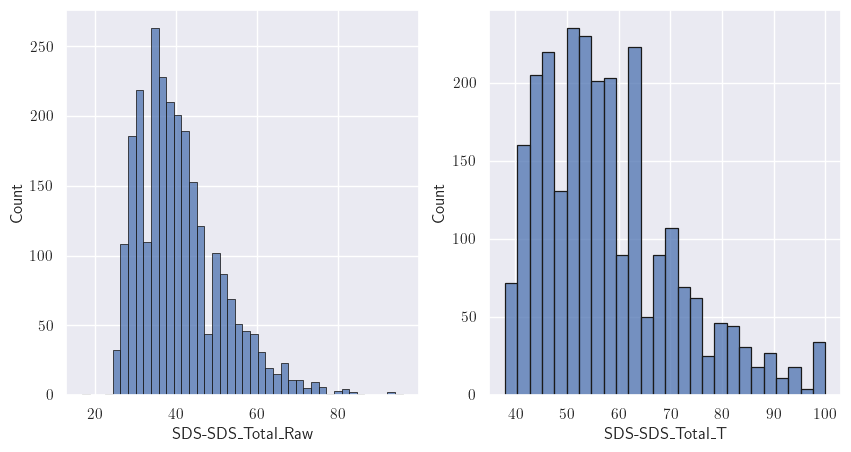

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

sns.histplot(train_df, x=SDS_TYPES[0], ax=ax[0], edgecolor='k')
sns.histplot(train_df, x=SDS_TYPES[1], ax=ax[1], edgecolor='k')
plt.show()

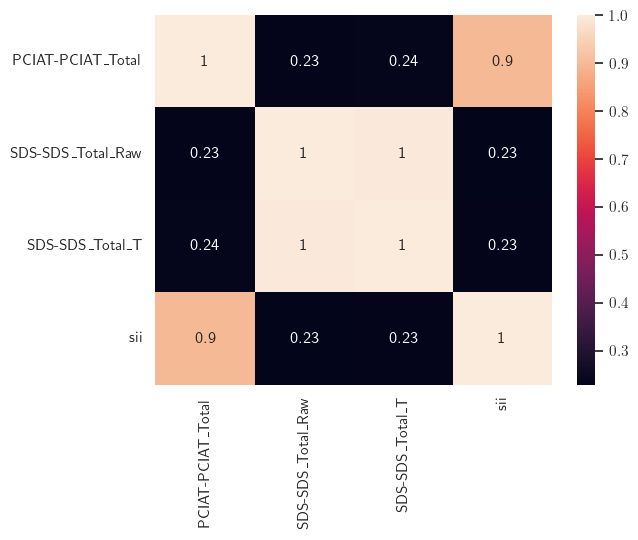

In [34]:
sns.heatmap(train_df.loc[:, ['PCIAT-PCIAT_Total', 'SDS-SDS_Total_Raw', 'SDS-SDS_Total_T', 'sii']].corr(), annot=True)
plt.show()

### Which features correlate most strongly with ```PCIAT_Total``` and ```sii```?
It will be interesting to check which features correlate most strongly (most positive and negative) with ```PCIAT_Total``` and ```sii``` values, even though there are a lot of missing entries in the dataset.

The function ```corr_with_sii()``` calculates the correlation between ```sii``` and other numeric features and sorts them in a descending order. The does not seem to show overly large correlations with ```sii``` with any feature other than the various ```PCIAT``` columns. Nevertheless, there are *relatively* strong positively correlations with height, age, weight, BMI and SDS total. The correlation between weight and ```sii``` may purely be a consequence of the correlation of the former with age.

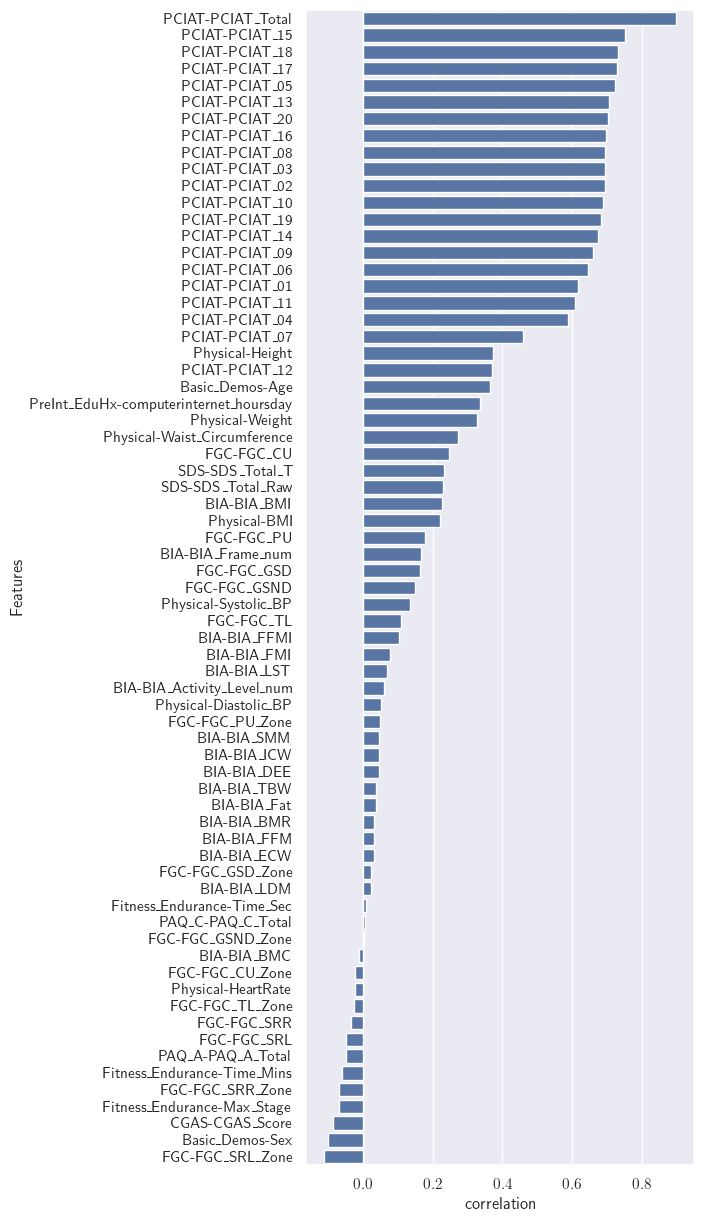

In [35]:
def corr_with_sii(data):
    data_numeric = data.select_dtypes(['int64', 'float64'])
    corr_matrix = data_numeric.corr()

    corr_with_sii = corr_matrix.loc['sii'].sort_values(ascending=False)
    return pd.DataFrame(
        {
            'Features': corr_with_sii.index.to_list()[1:],
            'correlation': corr_with_sii.to_list()[1:]
        }
    )

corr_with_sii = corr_with_sii(train_df)

fig, ax = plt.subplots(figsize=(5, 15))
sns.barplot(corr_with_sii, x='correlation', y='Features', ax=ax)
plt.show()

## Finding clusters in the data

The dataset contains $82$ features. Hence we are presented with the so-called *curse of dimensionality* in that there is no simple way to visualize such a high dimensional dataset. However, we can use *dimensionality reduction* techniques to see if the dataset displays localized clusters when mapped to a lower dimension. Here, we will use principal component analysis (PCA) on the subset of the data with ```sii``` values present. 

As a baseline, we will simply impute the missing values using some preferred statistic (mean or median) and perform the clustering.

In [36]:
def clipped(X):
    ''' 
    This function caps the numerical columns to the 1% and 99% quantiles on respective ends.
    '''
    X_clipped = X.copy()
    X_clipped.clip(
        lower=X_clipped.quantile(0.01),
        upper=X_clipped.quantile(0.99),
        axis=1
    )

    return X_clipped

# Pre-processing the date before applying unsupervised learning techniques

def preprocess(data, data_dictionary, label_missing=False):
    ''' 
    This function preprocesses the data. The inputs are the dataframe and data_dictionary with an optional
    label_missing argument set to 'False' by default. When 'False', the subset of the dataframe with labels present
    will be chosen. Else, the opposite will be true.
    
    The input dataframe is first split into numerical and categorical dataframes.
    The missing entries in the numerical and categorical features are imputed using the mean and mode respectively.
    Then, the numerical column is standardized.

    Except for the sex column, the other categorical features are not one-hot encoded and we assume an ordinal ordering.
    '''
    data_preprocessing = data.copy()

    ''' 
    The dataframe is first reduced to contain only the subset for which the sii values exist.
    '''
    if label_missing==False:
        data_reduced = data_preprocessing[data_preprocessing.loc[:,'sii'].notna()]
        data_reduced = data_reduced.reset_index() 

        X = data_reduced.iloc[:, 0:-1]
        y = data_reduced.loc[:, 'sii']
    else:
        data_reduced = data_preprocessing[data_preprocessing.loc[:,'sii'].isna()]
        data_reduced = data_reduced.reset_index() 

        X = data_reduced.iloc[:, 0:-1]

    ''' 
    The numeric separated out. Among them, we must also separate out that ones are the defined as 'categorial int' since
    they are also categorial features that have been encoded as integers.
    '''
    
    categorical_cols = data_dictionary[
        data_dictionary['Type'] == 'categorical int'
    ].loc[:, 'Field'].to_list()

    numerical_cols = data_dictionary[
        data_dictionary['Type'] == 'float'
    ].loc[:, 'Field'].to_list()

    X_categorcial = X.loc[:, categorical_cols]
    X_numerical = X.loc[:, numerical_cols]
    X_numerical = clipped(X_numerical)

    ct = ColumnTransformer(
        transformers=[
            ('ohe', OneHotEncoder(sparse_output=False), [categorical_cols[0]]),
            ('imp_cat', SimpleImputer(strategy='most_frequent'), categorical_cols[1:])
        ]
    )

    ct.set_output(transform='pandas')
    X_categorcial = ct.fit_transform(X_categorcial)

    pipeline = Pipeline(
        [
            ('imp_num', SimpleImputer(strategy='median')),
            ('ss', StandardScaler())
        ]
    )
    pipeline.set_output(transform='pandas')
    X_numerical = pipeline.fit_transform(X_numerical)

    #X = X_categorcial.join(X_numerical)
    if label_missing==False:
        return X_categorcial, X_numerical, y
    else:
        return X_categorical, X_numerical

X_categorical, X_numerical, y = preprocess(train_df, data_dict)

### Principal Component Analysis (PCA)
PCA is a powerful technique for handling the complexity of higher dimensional data by reducing it into a small number of dimensions called *principal components* which explains the greatest variance in the data. Hence, a dataset with a very large number of features can be compressed to one with only two or three dimensions. This, however, comes at a cost of some information loss.

PCA is designed to work on continuous data. However, a lot of the features here are ordinal. Here we first perform PCA only on the numerical features and then on both numerical and ordinal features (excluding sex) in the hopes that the ordinal features follow some hypothetical linear mapping.

We first check how many PCA components are needed to explain a goot chunk of the variance in the data. This is done through a *scree plot* which plots the number of PCA components with the *explained variance*. The scree plot on the scaled numerical data shows that over $70\%$ of the variance is explained by the first three PCA components. This is not great, but still something.

In [37]:
def scree_plot(X):
    pca = PCA()

    pca.fit_transform(X)
    #cov_matrix = pca.get_covariance()

    explained_variance = pca.explained_variance_ratio_.flatten()
    PCA_components = np.arange(1, len(explained_variance)+1)

    plt.scatter(PCA_components, explained_variance.cumsum(), c='red', edgecolors='black')
    plt.plot(PCA_components, explained_variance.cumsum(), c='red')
    plt.bar(PCA_components, explained_variance)
    plt.xlabel('PCA components', fontsize=15)
    plt.ylabel('Explained variance ratio', fontsize=15)
    plt.show()

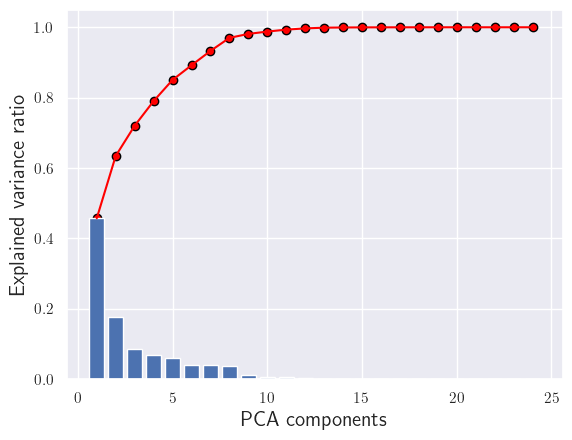

In [38]:
scree_plot(X_numerical)

Now, we perform PCA with ```n_components=3``` on the numerical data. We plot each PCA component against each other. However, for ```X_numerical```, we find no clusters appear. Will it be better with the inclusion of ```X_categorical```?

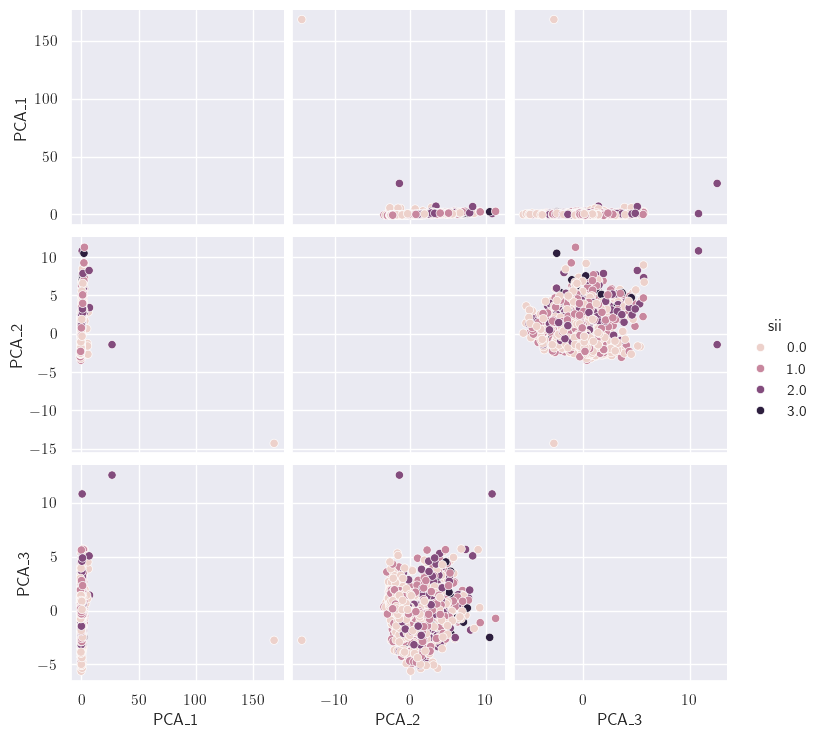

In [39]:
def PCA_pairplot(X, y, n_components, labeled=True):
    pca = PCA(n_components=n_components)
    X_PCA = pca.fit_transform(X)
    X_PCA = pd.DataFrame(X_PCA, columns=['PCA_{}'.format(n) for n in range(1, n_components+1)])
    
    if labeled==True:
        df = X_PCA.join(y)

        sns.pairplot(df, hue='sii', diag_kind='None')
        plt.show()
    else:
        df = X_PCA

        sns.pairplot(df, diag_kind='None')
        plt.show()

    return df

_ = PCA_pairplot(X_numerical, y, 3)

We now consider a joined list of ```X_categorial``` and ```X_numerical``` with the consideration that the categorial features are ordinal (which they are for the most part). In the ```X_joined``` set, we ignore the sex information since it is definitely a categorical variable with no intrinsic ordering. 

With the joint dataframe, we see that the features display very well structured clusters for ```sii=0,1,2,3``` with the greatest variations occuring along the $1^{\text{st}}$ and $3^{\text{rd}}$ PCA axes. However, we note that the data is not actually spatially separated in PCA space and they only appear separated when the color labels are applied.

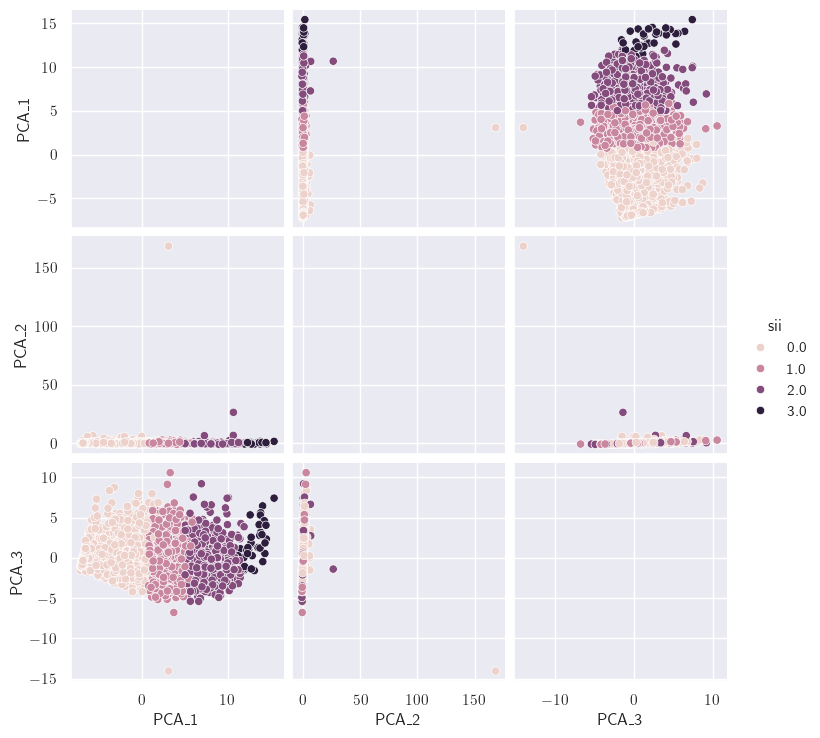

In [40]:
X_joined = X_categorical.iloc[:,2:].join(X_numerical)

PCA_df = PCA_pairplot(X_joined, y, 3)

In [41]:
fig = px.scatter_3d(
    PCA_df,
    x='PCA_1',
    y='PCA_2',
    z='PCA_3',
    color='sii', 
    title='PCA on labeled data'
)
fig.update_traces(
    marker=dict(size=5,line=dict(width=2, color='DarkSlateGrey'))
)
fig.update_layout(
    font_family="Times New Roman",
    title_font_family="Times New Roman",
)
fig.show()

Let us now apply PCA on the unlabeled portion of the dataset to check for patterns. Interestingly, PCA on the unlabeled set shows more variation on the $\text{PCA}_2$ axis while retaining the cluster on the $\text{PCA}_1-\text{PCA}_3$ plane.

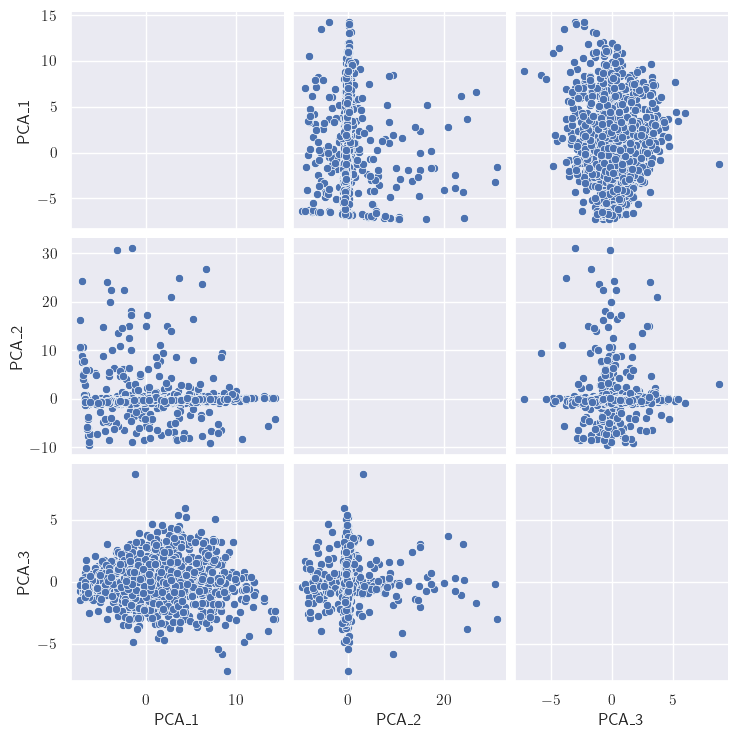

In [42]:
X_numerical_2, X_categorical_2 = preprocess(train_df, data_dict, label_missing=True)

X_joined_2 = X_categorical_2.iloc[:, 2:].join(X_numerical_2)

PCA_df_2 = PCA_pairplot(X_joined_2, y, 3, labeled=False)

We can now apply $k$-means clustering to the unlabeled dataset. Since we are aware that the dataset should contain four ```sii``` labels, we initialized ```KMeans()``` with ```n_cluster=4```. The generated labels are then joined to the processed, unlabeled data, which is then plotted. The $k$-means algorithm is able to identify four clusters, albeit with greater variance along the $\text{PCA}_2$ axis.

In [43]:
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=10)
kmeans.fit(X_joined_2)

knn_labels = kmeans.labels_

In [44]:
knn_labels = pd.DataFrame(knn_labels, columns=['knn_labels'])

PCA_df_2_knn = PCA_df_2.join(knn_labels)

fig = px.scatter_3d(
    PCA_df_2_knn,
    x='PCA_1',
    y='PCA_2',
    z='PCA_3',
    color='knn_labels',
    title='PCA on unlabeled data with k-means'
)
fig.update_traces(
    marker=dict(size=5,line=dict(width=2, color='DarkSlateGrey'))
)
fig.update_layout(
    margin=dict(l=20, r=20, t=20, b=20),
    font_family="Times New Roman",
    title_font_family="Times New Roman",
)
fig.show()

In [45]:
manifold_labeled = umap.UMAP(n_components=3, init='random').fit_transform(X_joined)
manifold_labeled_2 = umap.UMAP(n_components=3, init='random').fit_transform(X_joined_2)

In [46]:
manifold_labeled = pd.DataFrame(manifold_labeled)

fig = px.scatter_3d(
    manifold_labeled,
    x=0,
    y=1,
    z=2, 
    color=y
)

fig.update_traces(
    marker=dict(size=5,line=dict(width=2, color='DarkSlateGrey'))
)
fig.update_layout(
    margin=dict(l=20, r=20, t=20, b=20),
    font_family="Times New Roman",
    title_font_family="Times New Roman",
)

fig.show()

In [47]:
manifold_labeled_2 = pd.DataFrame(manifold_labeled_2)

fig = px.scatter_3d(
    manifold_labeled_2,
    x=0,
    y=1,
    z=2, 
    color=knn_labels.iloc[:,0]
)

fig.update_traces(
    marker=dict(size=5,line=dict(width=2, color='DarkSlateGrey'))
)
fig.update_layout(
    margin=dict(l=20, r=20, t=20, b=20),
    font_family="Times New Roman",
    title_font_family="Times New Roman",
)

fig.show()

## Conclusions
Here we performed a detailed EDA on the ```train.csv``` data. We find that the data contains substantial outliers in all the subcategories. Particular examples of these outliers are in the ```Physical``` and ```BIA``` categories. In the former category, along with erroneous blood pressure entries, we observe some very high and low heart rates and weights. In the latter category, we also see some points that give rise to nonsensical data. These outliers and erroneous entries need to be fixed before a training algorithm is created.

Moving on to the missing entries in the various features, in this notebook we used a very simple imutation technique where the numerical and categorical features are imputed using median and mode respectively. Evidently, this strategy is very simple and one must devise a more robust way to filling in these values using patterns present in the data. This notebook has not taken into account the actigraphy data and it can be assumed that some of these missing values can be filled in with the actigraphy data taken into account.

Finally, we perform PCA on the labeled and unlabeled sets. PCA on the labeled set reveals clear clusters of four ```sii``` labels. Performing $k$-means clustering on the PCA result of the unlabeled set similarly reveals the existence of similar clusters.